# LCPA 23-24 - "Hierarchical Mergers of Binary Black Holes"

<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |2109310         |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |2104269         |           

## 1. Introduction

A binary black hole (BBH) can form via close encounters with black holes (BHs) in a dense stellar environment, such as a nuclear star cluster (NSC), a globular cluster (GC) or a young star cluster (YSC). NSCs are very massive (~ $10^5 - 10^8 \, M_\odot$) star clusters lying at the center of some galaxies, including the Milky Way. GCs are old (~ 12 Gyr) massive (~ $10^4 - 10^6 M_\odot$) stellar clusters lying in the halo of galaxies. YSC are young (< 100 Myr) stellar clusters forming mostly in the disk of a galaxy.  

Several channels can lead to the formation of BBHs. But the distinctive signature of the dynamical scenario is the formation of hierarchical mergers (IMs), i.e. repeated mergers of stellar-origin BHs that build up more massive ones. This process is possible only in dense star clusters, where the merger remnant, which is initially a single BH, can pair up by dynamical exchanges or three-body encounters. The main obstacle to the formation of second-generation BHs via hierarchical mergers is the relativistic kick that the merger remnant receives at birth. This kick can be up to several thousand km/s. Hence, the interplay between the properties of the host star cluster (e.g., its escape velocity), those of the first-generation BBH population and the magnitude of the kick decides the maximum mass of a merger remnant in a given environment.  

A property that is being studied is that IM can build up IMBHs and also partially fill the pair-instability (PI) mass gap between ~60 and ~120 $M_\odot$, explaining the formation of BBHs like GW190521.

#### Hierarchical mergers
When two stellar-born BHs merge via GW emission, their merger remnant is called second-generation (2g) BH. The 2g BH is a single object at birth. However, if it is retained inside its host star cluster, it may pair up dynamically with another BH. This gives birth to what we call a second-generation (2g) BBH, i.e. a binary black hole that hosts a 2g black hole. If a 2g binary black hole merges again, it gives birth to a third-generation (3g) BH, and so on. In this way, repeated black hole mergers in star clusters can give birth to hierarchical chains of mergers, leading to the formation of more and more massive black holes.

## 2. Goal of the project

Understand the differences between hierarchical binary black hole mergers in NSCs, GCc and YSc, by looking at a set of simulated BBHs. 
Our analysis will be carried out with classification ML algorithms, such as Random Forest and XGBoost. We will then proceed to analyze the importance of features to understand the properties of systems of BBHs.   

The idea is to split the analysis into two parts:

- Based on the features of the BBHs systems, figure out to which host star cluster these systems belong. 
  It's a classification problem with labeling the `label` column of the dataset corresponding to `0 -> GC, 1 -> NSC, 2 -> YSC`. Feature importance analysis will tell us which features are most important to understand which system belongs to which host stellar cluster.

- Analyze each stellar cluster independently. To do this we added a new label column `label_ngen`: `0` if the system has no other mergers beyond the 2nd generation; `1` if the system evolves beyond the 2nd generation.
  This is still a classification problem, this time with respect to `label_ngen`. Analysis of features importance will tell us which features are most important that lead systems to evolve and which do not.

To do this in a more detailed way, both globally (all labels together) and locally (single label), we will use `SHAP` values (Section 6).  

To have a cleaner notebook we created a file (`hmbh.py`) containing the functions needed to create the dataset, to train the ML models and to plot the results.

# 3. Dataset

The dynamical simulations were run for each host star cluster, with 12 different metallicities each. The files are found in the folders and subfolders: 

```python
folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']
```

Each `nth_generation.txt` dataset is composed of 28 columns. Among them, we selected these: 

```python
cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27']
```

- c0: Identifier of the binary
- c1: Mass of the primary black hole in solar masses
- c2: Mass of the secondary black hole
  
- c3: Dimensionless spin magnitude of the primary black hole
- c4: Dimensionless spin magnitude of the secondary black hole
- c7: Initial semi-major axis of the binary black hole in solar radii
- c8: Initial orbital eccentricity of the binary black hole

- c9: Time requested for the dynamical pair up of the system in Myr
- c13: Time elapsed from the first-gen formation until the merger of the nth-gen system

- c15: Mass of the remnant
- c16: Dimensionless spin magnitude of the remnant black hole
- c17: Escape velocity from star cluster in km/s
- c25: Total mass of the stellar cluster
- c27: Number of generation of the system

We added two new columns, in the creation of the dataset:
- `label`: Identifies to which host star cluster a system belongs `0 -> GC, 1 -> NSC, 2 -> YSC`
- `label_ngen`: `0` if the system has no other mergers beyond the 2nd generation; `1` if the system evolves beyond the 2nd generation

### Import modules

In [1]:
import hmbh as h # custom module for data analysis

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

## 3.1 Dataset creation

In order to create the dataset we use the custom function `create_dataset`. It used the `polars.DataFrame` object. 
Polars is a fast DataFrame library for manipulating structured data. To be fast it optimizes queries to reduce unneeded work/memory allocations and adheres to a strict schema (data types should be known before running the query). 
Polars leverages the concept of `LazyFrame`, Polars doesn't run each query line-by-line but instead processes the full query end-to-end. This lazy evaluation strategy allows for better memory management, making it possible to work with datasets that are too large to fit into RAM (it inherits the concept of "lazy" from Dask).

The speed-up is astonishing: an improvement of ~ 900% wrt using Pandas!

In the creation of the dataset, we filter out those systems that take longer than Hubble time (~ 13.6 Gyr) to merge.
After creating the dataset, we rename the columns and we add the column `label_ngen`.

In [2]:
path = '../data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']


df = h.create_dataset(path, folder, metallicity, cols) # dataset creation

df = h.rename_columns(df, new_cols) # rename columns

df = h.get_label_ngen(df) # get label for n_gen

In [3]:
df.head(5)

shape: (5, 17)
┌─────────┬───────────┬───────────┬──────────┬───┬───────┬───────┬────────┬────────────┐
│ ID      ┆ bh_mass1  ┆ bh_mass2  ┆ spin1    ┆ … ┆ n_gen ┆ label ┆ met    ┆ label_ngen │
│ ---     ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---    ┆ ---        │
│ str     ┆ f64       ┆ f64       ┆ f64      ┆   ┆ i64   ┆ i64   ┆ f64    ┆ i32        │
╞═════════╪═══════════╪═══════════╪══════════╪═══╪═══════╪═══════╪════════╪════════════╡
│ 2.0.0   ┆ 28.497396 ┆ 23.848129 ┆ 0.734705 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 18.0.0  ┆ 38.172095 ┆ 29.913274 ┆ 0.753993 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 34.0.0  ┆ 60.53033  ┆ 53.519905 ┆ 0.720625 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 38.0.0  ┆ 14.480868 ┆ 13.043004 ┆ 0.725751 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 103.0.0 ┆ 19.224383 ┆ 15.611048 ┆ 0.742771 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
└─────────┴───────────┴───────────┴──────────┴───┴───────┴───────┴────────┴────────────┘

# 4. Visual description
Let's start by comparing the main features (mass, spin, escape velocity) between different clusters. The goal is to understand "by eye" how the features are distributed inside our dataset and try to find some kind of correlation with respect to the labels. Later, we will need the support of the feature importance insight by ML techniques, that will prove or not the following first set of interpretations.

### 4.1 Mass distribution

The plots show the distribution of primary and secondary black hole (BH) masses in 2nd-generation and > 2nd-generation systems, categorized by their hosting bodies: Globular Clusters (GCs), Young Stellar Clusters (YSCs), and Nuclear Star Clusters (NSCs). Each graph is divided based on the metallicity levels 0.0002, 0.002, and 0.02. 

 1. **Systems of 2nd generation**: the median masses of the BHs involved in the dynamical merger are larger in GCs and YSCs with respect to NCSs. This addresses the high _escape velocity_ of NSCs, which are more likely to retain hierarchical mergers than other star clusters. Instead, lighter BHs are ejected by SN kicks from lower-mass clusters. Regarding _metallicity_, metal-poor stellar clusters retain primary BHs of higher masses because of stellar winds, while their mass decreases inside metal-rich clusters. In the case of GCs, the masses cover approximately the entire range, while YSCs favor dynamical encounters, producing larger masses.

 2. **Systems of >2nd generation**: the dynamical merger between the BHs leads to the formation of more massive BHs. We are under the assumption that only the BHs receiving a natal kick lower than the escape velocity have a chance to pair up dynamically. NCSs witness the formation of more low-mass BHs. The masses follow the same behavior as those in systems of 2nd generation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

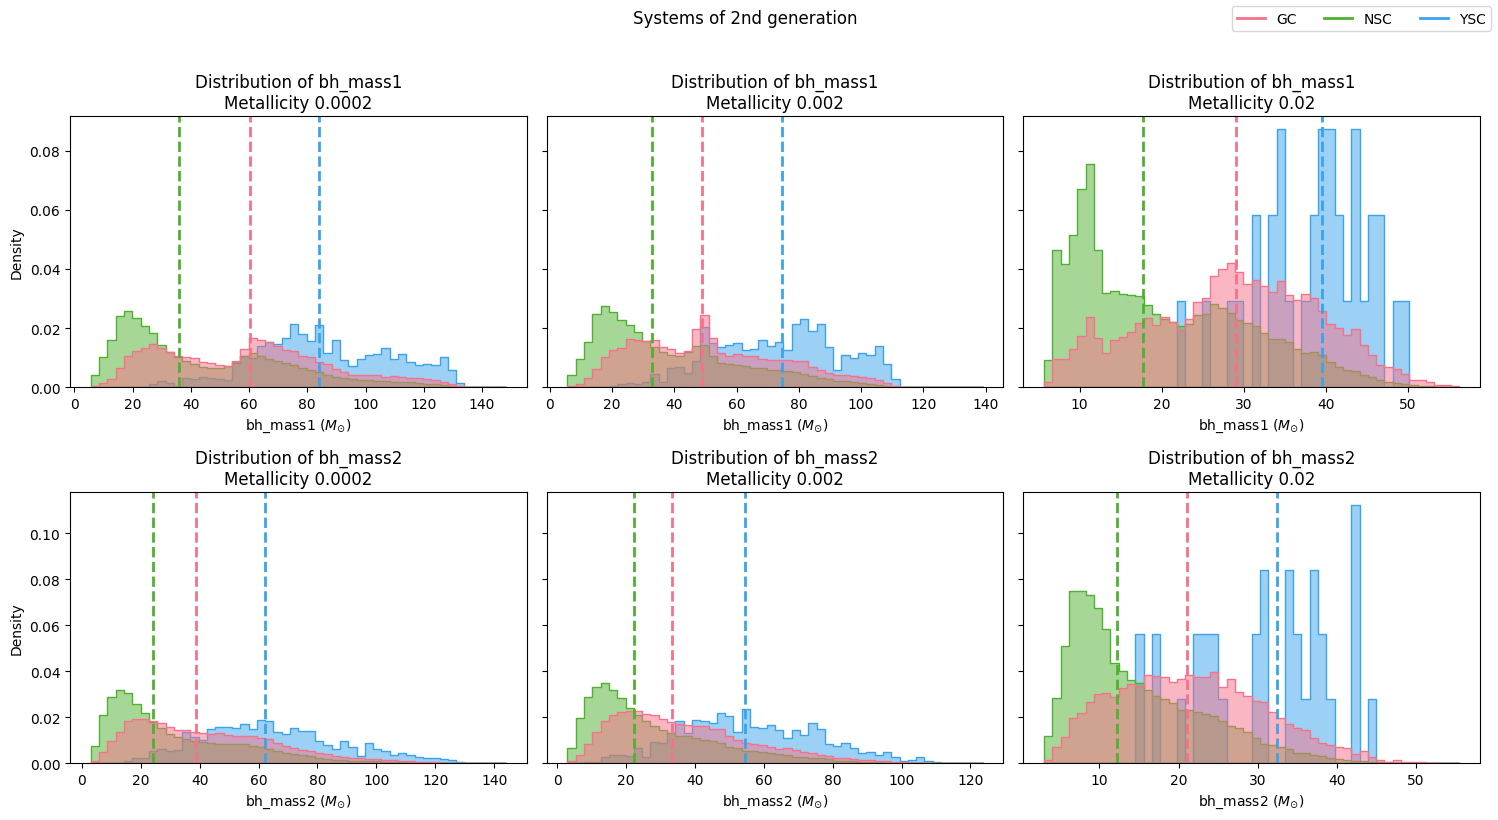

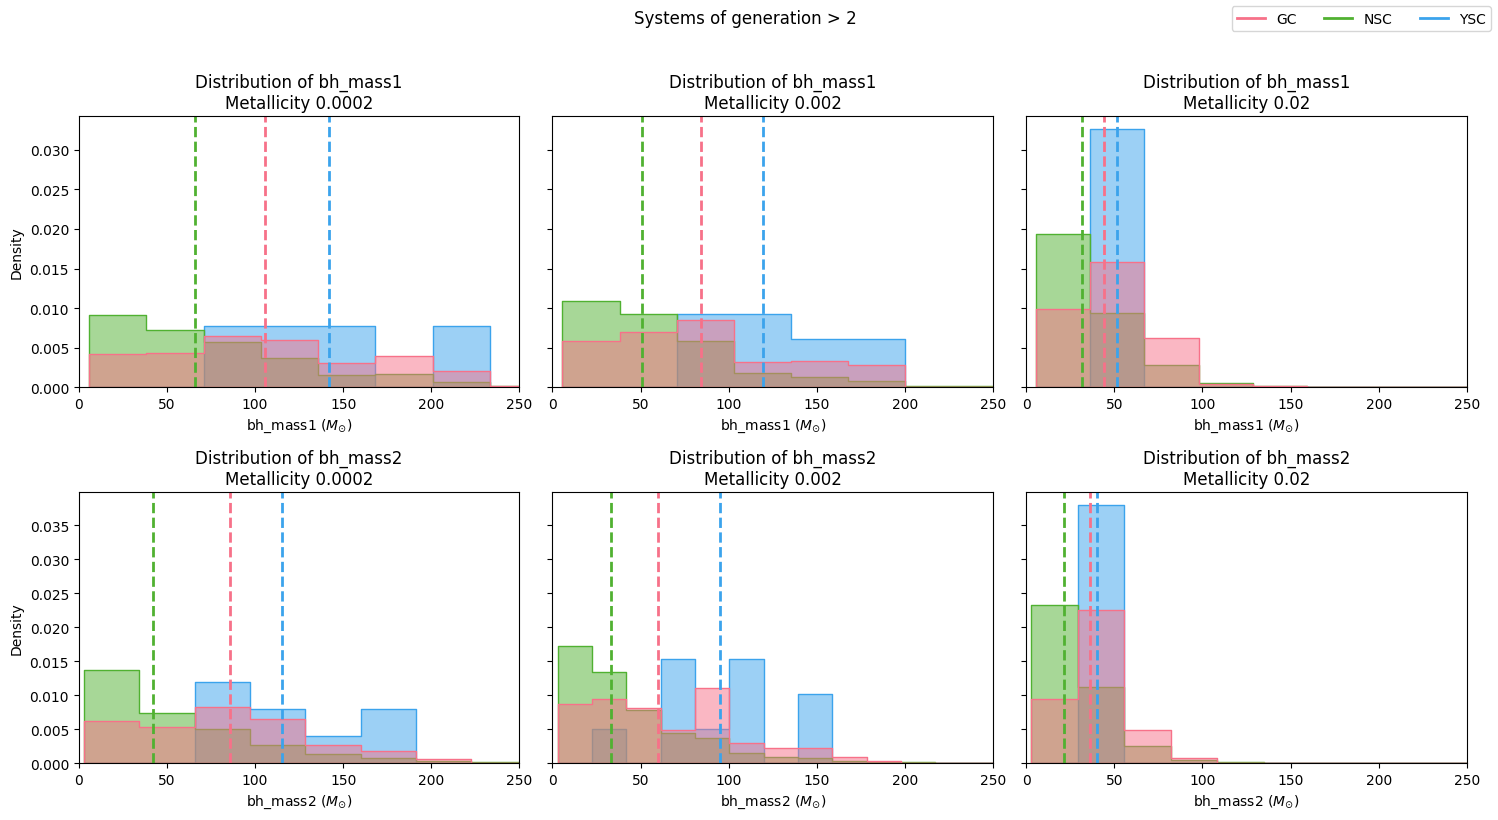

Mean and Median Mass per Cluster (Generation = 2):
 label  mean_mass_bh1  median_mass_bh1  mean_mass_bh2  median_mass_bh2
     0      88.617281        80.655354      67.520177        60.489732
     1      65.331452        48.230897      46.402038        31.487629
     2     117.506453       106.219579      92.731176        87.009097

Mean and Median Mass per Cluster (Generation > 2):
 label  mean_mass_bh1  median_mass_bh1  mean_mass_bh2  median_mass_bh2
     0      50.234588        44.257545      39.270213        36.023724
     1      37.888650        31.715064      27.725532        21.719342
     2      51.414220        51.414220      40.354478        40.354478


In [4]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (bh_mass1 and bh_mass2)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot histogram for bh_mass1
    sns.histplot(data=df_metallicity.to_pandas(), x='bh_mass1', hue='label', bins=50, kde=False, ax=axes[0, i], palette=custom_palette, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[0, i].set_title(f'Distribution of bh_mass1\nMetallicity {met}')
    axes[0, i].set_xlabel(r'bh_mass1 ($M_{\odot}$)')
    axes[0, i].set_ylabel('Density')

    # Plot histogram for bh_mass2
    sns.histplot(data=df_metallicity.to_pandas(), x='bh_mass2', hue='label', bins=50, kde=False, ax=axes[1, i], palette=custom_palette, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[1, i].set_title(f'Distribution of bh_mass2\nMetallicity {met}')
    axes[1, i].set_xlabel(r'bh_mass2 ($M_{\odot}$)')
    axes[1, i].set_ylabel('Density')

    # Add vertical lines for median values in bh_mass1
    for label in df_metallicity['label'].unique():
        median_bh_mass1 = df_metallicity.filter(df_metallicity['label'] == label).to_pandas()['bh_mass1'].median()
        axes[0, i].axvline(median_bh_mass1, color=custom_palette[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in bh_mass2
    for label in df_metallicity['label'].unique():
        median_bh_mass2 = df_metallicity.filter(df_metallicity['label'] == label).to_pandas()['bh_mass2'].median()
        axes[1, i].axvline(median_bh_mass2, color=custom_palette[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots
    axes[0, i].legend().set_visible(False)
    axes[1, i].legend().set_visible(False)

# Add a common legend for all subplots
legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]
#fig.legend(handles=custom_lines, loc='upper right',ncol=len(legend_labels))
for i, ax in enumerate(axes.flat):
    handles, labels = ax.get_legend_handles_labels()

# Add a common legend outside the loop for the first set of subplots
fig.legend(handles=custom_lines, labels=legend_labels.values(), loc='upper right', ncol=len(legend_labels))


# Add a subtitle for the entire group of subplots
fig.suptitle('Systems of 2nd generation', y=1.02)

# Adjust layout
plt.tight_layout()

# Create subplots for the second generation
fig2, axes2 = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (bh_mass1 and bh_mass2) for the second generation
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and second generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for bh_mass1
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='bh_mass1', hue='label', bins=100, kde=False, ax=axes2[0, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[0, i].set_title(f'Distribution of bh_mass1\nMetallicity {met}')
    axes2[0, i].set_xlabel(r'bh_mass1 ($M_{\odot}$)')
    axes2[0, i].set_ylabel('Density')

    # Plot histogram for bh_mass2
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='bh_mass2', hue='label', bins=100, kde=False, ax=axes2[1, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[1, i].set_title(f'Distribution of bh_mass2\nMetallicity {met}')
    axes2[1, i].set_xlabel(r'bh_mass2 ($M_{\odot}$)')
    axes2[1, i].set_ylabel('Density')

    # Add vertical lines for median values in bh_mass1
    for label in df_metallicity_gen2['label'].unique():
        median_bh_mass1_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['bh_mass1'].median()
        axes2[0, i].axvline(median_bh_mass1_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in bh_mass2
    for label in df_metallicity_gen2['label'].unique():
        median_bh_mass2_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['bh_mass2'].median()
        axes2[1, i].axvline(median_bh_mass2_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots
    axes2[0, i].legend().set_visible(False)
    axes2[1, i].legend().set_visible(False)

    #Set x-axis limits
    axes2[0, i].set_xlim(0, 250)
    axes2[1, i].set_xlim(0, 250)

# Add a common legend for all subplots for the second generation
#fig2.legend(handles=custom_lines, loc='upper right',ncol=len(legend_labels))
for i, ax in enumerate(axes2.flat):
    handles, labels = ax.get_legend_handles_labels()

# Add a common legend outside the loop for the second set of subplots
fig2.legend(handles=custom_lines, labels=legend_labels.values(), loc='upper right', ncol=len(legend_labels))

# Add a subtitle for the entire group of subplots for the second generation
fig2.suptitle('Systems of generation > 2', y=1.02)

# Adjust layout for the second generation subplots
plt.tight_layout()

# Display both sets of subplots
plt.show()

# Compute the mean mass for primary and secondary bh in each cluster for the second generation
df_gen2 = df.filter(df['label_ngen'] == 1)
mean_median_mass_per_cluster_gen2 = df_gen2.group_by('label').agg(
    pl.col('bh_mass1').mean().alias('mean_mass_bh1'),
    pl.col('bh_mass1').median().alias('median_mass_bh1'),
    pl.col('bh_mass2').mean().alias('mean_mass_bh2'),
    pl.col('bh_mass2').median().alias('median_mass_bh2')
)

# Display the mean mass per cluster for the second generation
print("Mean and Median Mass per Cluster (Generation = 2):")
print(mean_median_mass_per_cluster_gen2.to_pandas().to_string(index=False))

# Compute the mean and median mass for primary and secondary bh in each cluster for the second generation
mean_median_mass_per_cluster_gt2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('bh_mass1').mean().alias('mean_mass_bh1'),
    pl.col('bh_mass1').median().alias('median_mass_bh1'),
    pl.col('bh_mass2').mean().alias('mean_mass_bh2'),
    pl.col('bh_mass2').median().alias('median_mass_bh2')
)


# Display the mean mass per cluster for the second generation
print()
print("Mean and Median Mass per Cluster (Generation > 2):")
print(mean_median_mass_per_cluster_gt2.to_pandas().to_string(index=False))

## 4.2 Spin distribution
The spin of a BH is a measure of the angular momentum of the progenitor star. Three-body interactions in hierarchical systems can result in spin-flip events, where the orientation of a black hole's spin changes significantly. The conservation of angular momentum plays a crucial role in determining the spins of the resulting black holes after a merger.

The distribution of the dimensionless spins looks similar in NSCs, GCs and YSCs, by construction, because in the simulation the same spin models have been assumed. Most first-generation mergers have precessing spin squeezed toward low values (∼ 0.1 − 0.2), while nth-generation mergers tend to have high values of $\chi_\text{p}$ ∼ 0.7. This creates a sort of spin gap between ∼ 0.3 and ∼ 0.6. 

Different spin magnitudes do not significantly impact the shape of the mass function, the maximum mass and the position of the peak, but they have a strong effect on the number of nth-generation mergers. This effect is particularly important for YSCs and GCs, which have a lower escape velocity than NSCs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

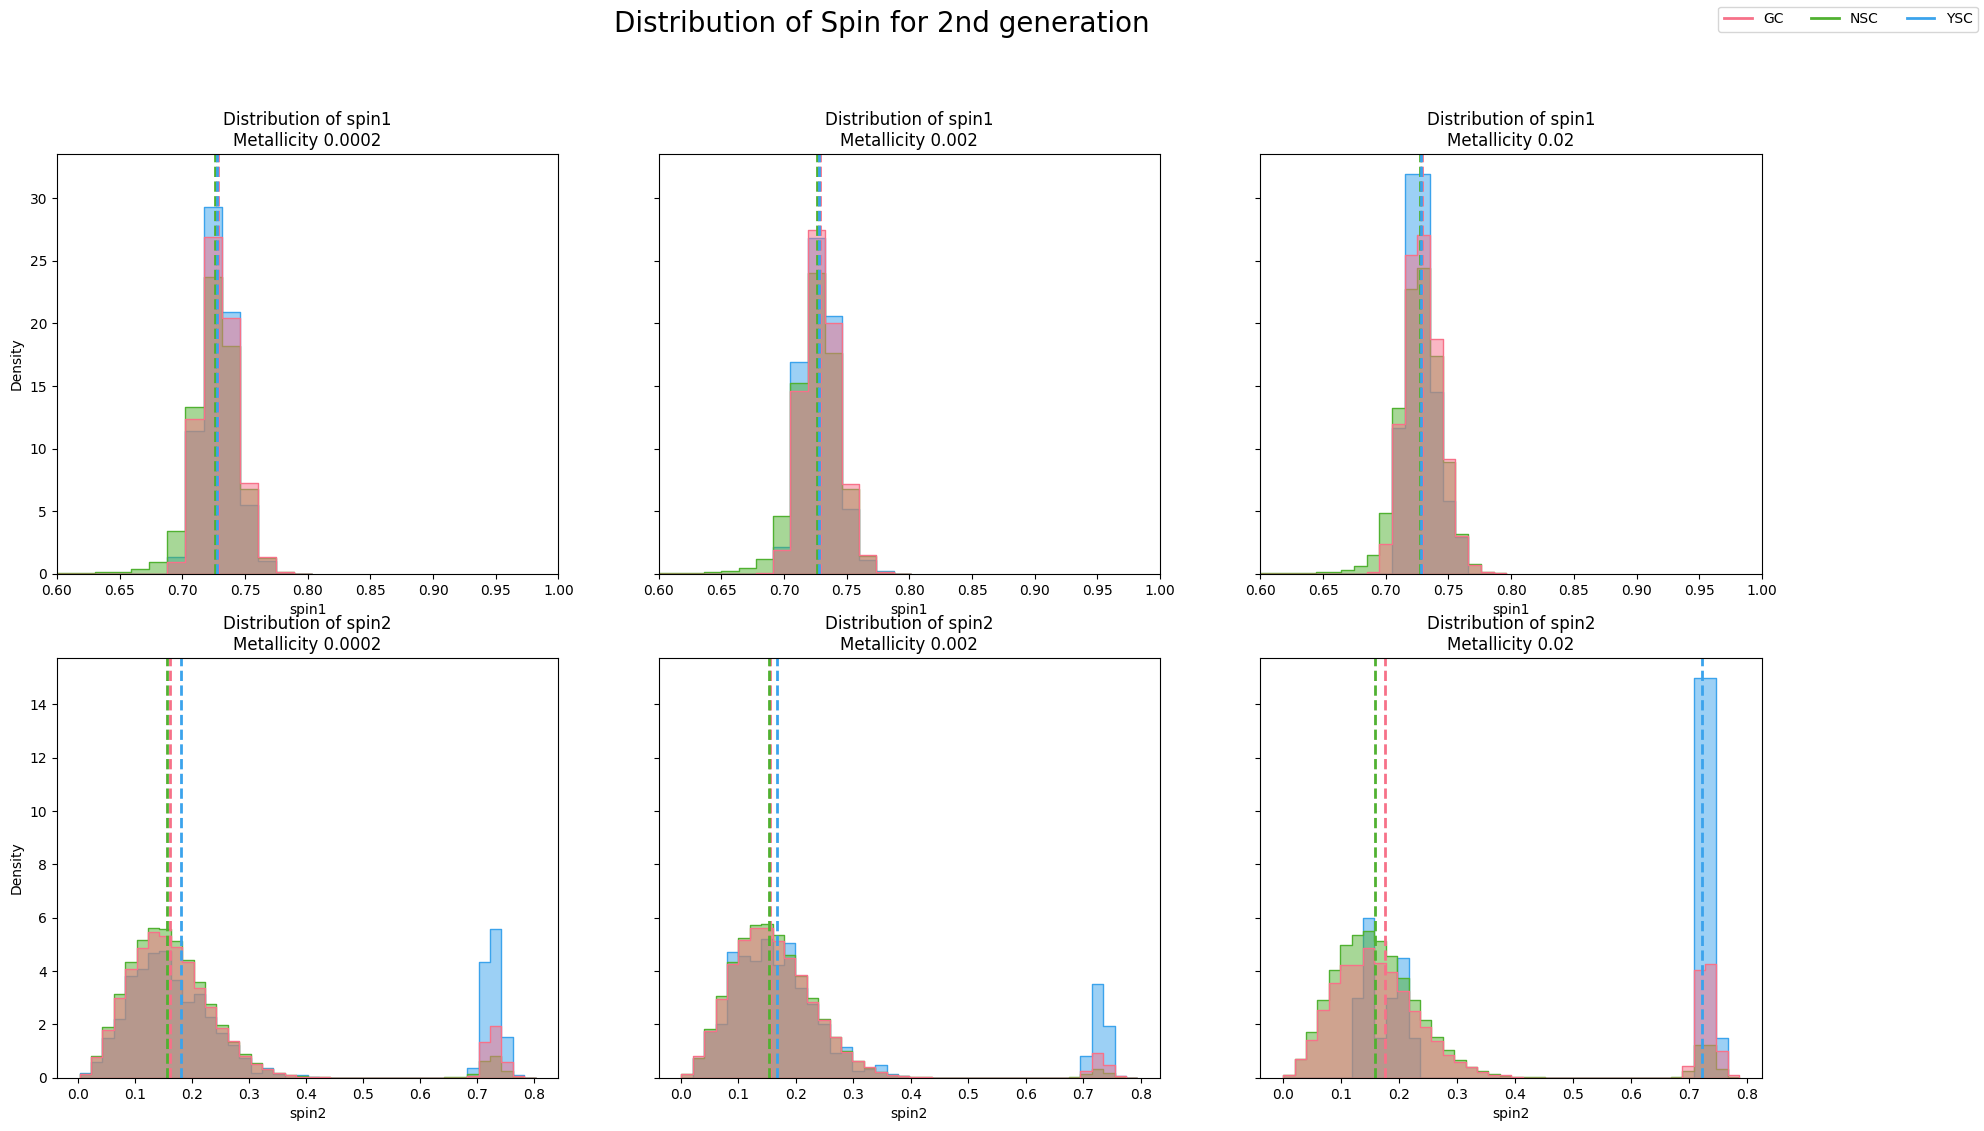

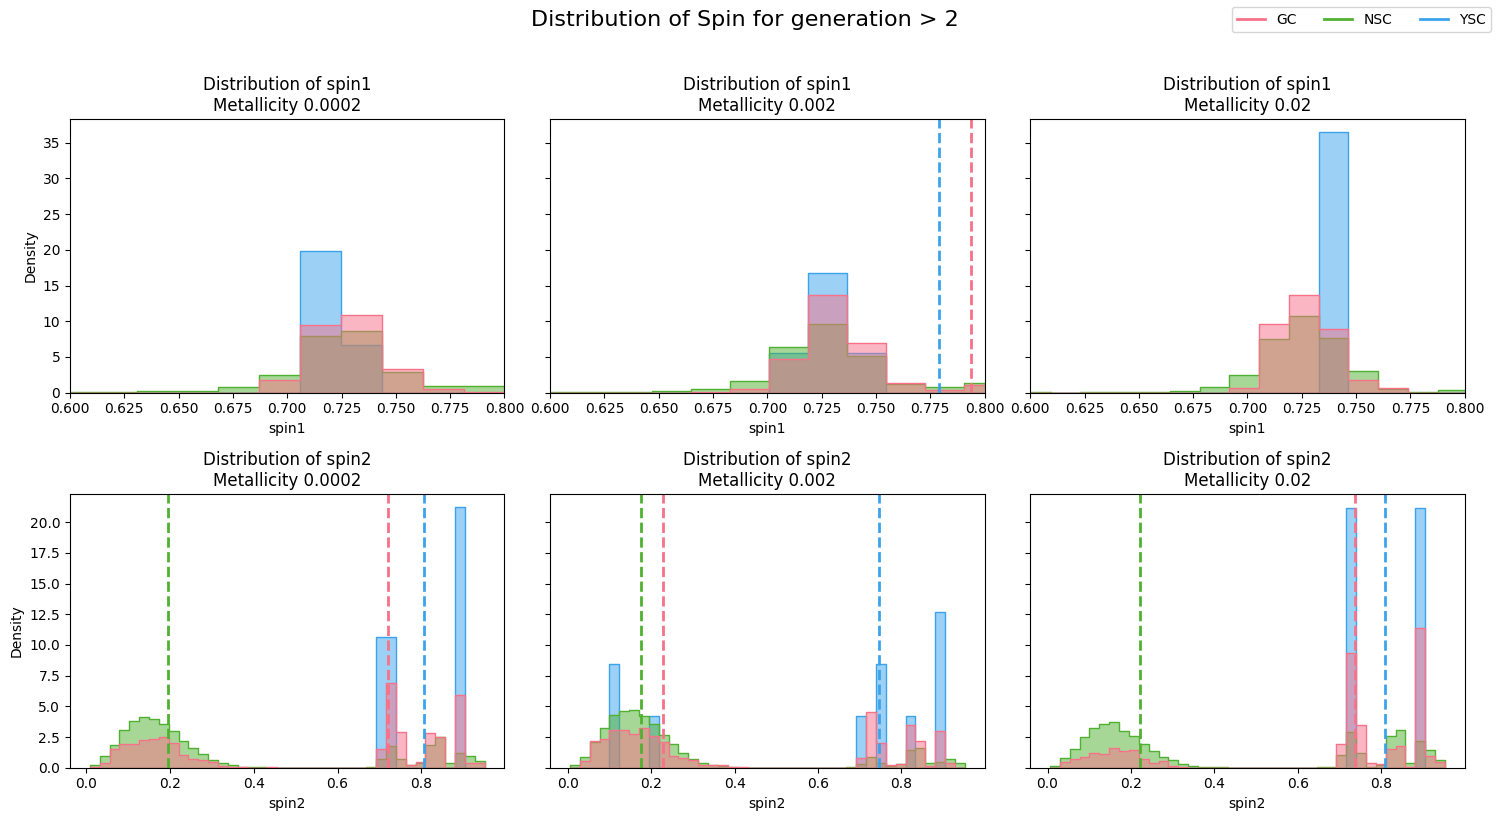

<Figure size 640x480 with 0 Axes>

Mean and Median Spin per Cluster (2nd generation):
 label  mean_spin1  median_spin1  mean_spin2  median_spin2
     0    0.729476      0.728580    0.269120      0.175352
     1    0.726689      0.727349    0.193617      0.158807
     2    0.729278      0.727714    0.516008      0.721387

Mean and Median Spin per Cluster (generation > 2):
 label  mean_spin1  median_spin1  mean_spin2  median_spin2
     0    0.806049      0.821695    0.646590      0.737456
     1    0.795834      0.816469    0.409801      0.220706
     2    0.814856      0.814856    0.809915      0.809915


In [5]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(2, len(metallicities), figsize=(22, 12), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (spin1 and spin2)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for spin1 in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='spin1', hue='label', bins=40, kde=False, ax=axes[0, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[0, i].set_title(f'Distribution of spin1\nMetallicity {met}')
    axes[0, i].set_xlabel('spin1')
    axes[0, i].set_ylabel('Density')
    axes[0, i].set_xlim([0.6, 1.0])

    # Plot histogram for spin2 in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='spin2', hue='label', bins=40, kde=False, ax=axes[1, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[1, i].set_title(f'Distribution of spin2\nMetallicity {met}')
    axes[1, i].set_xlabel('spin2')
    axes[1, i].set_ylabel('Density')

    # Add vertical lines for median values in spin1 for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_spin1_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['spin1'].median()
        axes[0, i].axvline(median_spin1_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in spin2 for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_spin2_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['spin2'].median()
        axes[1, i].axvline(median_spin2_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[0, i].legend().set_visible(False)
    axes[1, i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for spin1 in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='spin1', hue='label', bins=40, kde=False, ax=axes2[0, i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[0, i].set_title(f'Distribution of spin1\nMetallicity {met}')
    axes2[0, i].set_xlabel('spin1')
    axes2[0, i].set_ylabel('Density')
    #Add limits to x-axis
    axes2[0, i].set_xlim([0.6, 0.8])

    # Plot histogram for spin2 in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='spin2', hue='label', bins=40, kde=False, ax=axes2[1, i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[1, i].set_title(f'Distribution of spin2\nMetallicity {met}')
    axes2[1, i].set_xlabel('spin2')
    axes2[1, i].set_ylabel('Density')

    # Add vertical lines for median values in spin1 for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_spin1_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['spin1'].median()
        axes2[0, i].axvline(median_spin1_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in spin2 for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_spin2_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['spin2'].median()
        axes2[1, i].axvline(median_spin2_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)


    # Remove legend for individual plots for generation > 2
    axes2[0, i].legend().set_visible(False)
    axes2[1, i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Spin for 2nd generation', y=1,fontsize=20)

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Spin for generation > 2', y=1.02,fontsize=16)

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median spin for spin1 and spin2 in each cluster for 2nd generation
mean_median_spin_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('spin1').mean().alias('mean_spin1'),
    pl.col('spin1').median().alias('median_spin1'),
    pl.col('spin2').mean().alias('mean_spin2'),
    pl.col('spin2').median().alias('median_spin2')
)

# Compute the mean and median spin for spin1 and spin2 in each cluster for generation > 2
mean_median_spin_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('spin1').mean().alias('mean_spin1'),
    pl.col('spin1').median().alias('median_spin1'),
    pl.col('spin2').mean().alias('mean_spin2'),
    pl.col('spin2').median().alias('median_spin2')
)

# Display the mean and median spin per cluster for 2nd generation
print("Mean and Median Spin per Cluster (2nd generation):")
print(mean_median_spin_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median spin per cluster for generation > 2
print()
print("Mean and Median Spin per Cluster (generation > 2):")
print(mean_median_spin_per_cluster_gen_gt2.to_pandas().to_string(index=False))

## 4.3 Mass distribution of the BH remnant resulting from the merger 

The plots show the distribution of remnant masses for 2nd and >2nd-generation systems, categorized by their hosting bodies.

1. **Globular Clusters (GC)**: GCs shows a broader distribution for remnant masses at all metallicity levels. This could indicate a wider variety of remnant masses within GCs, possibly due to the dense stellar environment leading to more frequent and diverse interactions.

2. **Nuclear Star Clusters (NSC)**: NSC, especially at higher metallicity (0.02), exhibits a concentration towards lower remnant masses. This could be due to stellar wind mass loss being more significant in stars with higher metallicity, leading to the formation of less massive remnants.

3. **Young Stellar Clusters (YSC)**: YSC produces more massive remnants because of the environment's exceptional density.

The mass function of nth-generation BBHs peaks at values ∼ 30 − 100 $M_\odot$ in all considered star clusters. The main difference between NSCs, GCs and YSCs is the maximum mass of nth-generation BBHs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


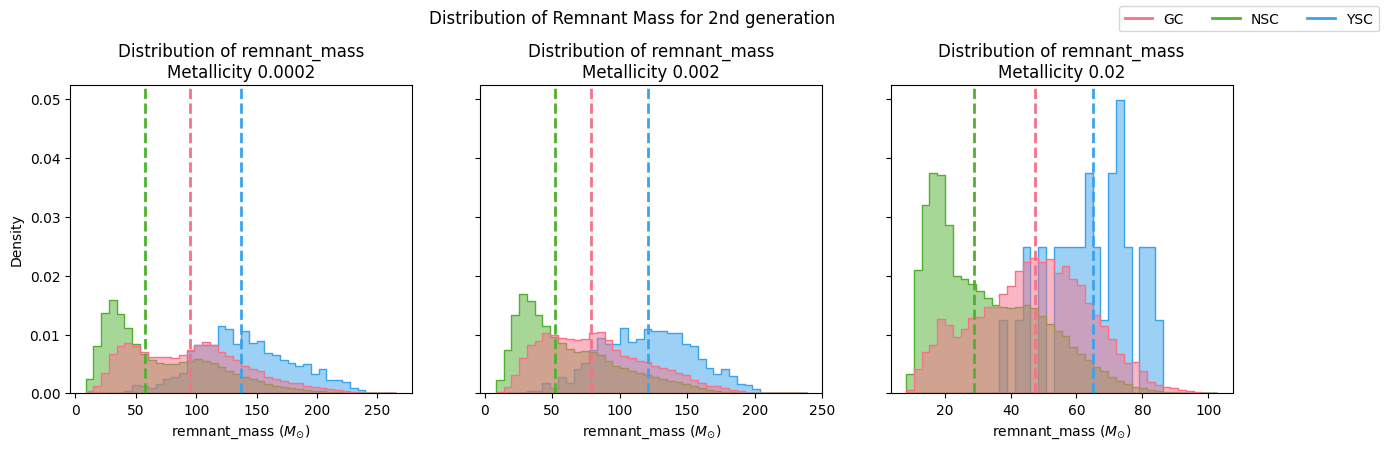

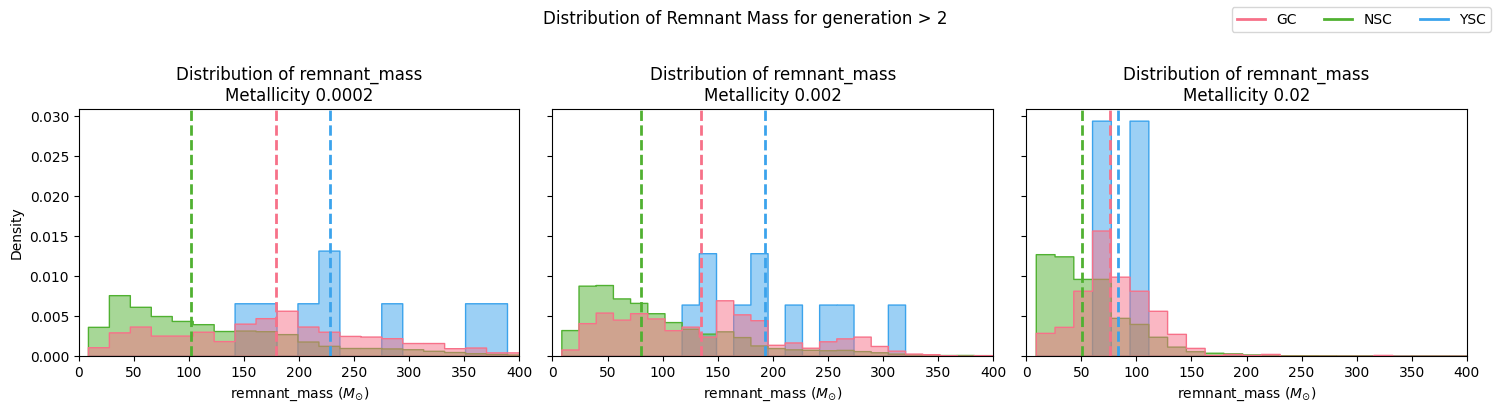

Mean and Median Remnant Mass per Cluster (2nd generation):
 label  mean_remnant_mass  median_remnant_mass
     0          46.728259            47.396678
     1          32.718699            28.805095
     2          64.322856            64.872091

Mean and Median Remnant Mass per Cluster (generation > 2):
 label  mean_remnant_mass  median_remnant_mass
     0          81.768551            76.179061
     1          60.293688            50.889388
     2          83.523150            83.523150


In [6]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Loop through each metallicity for remnant_mass
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for remnant_mass in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='remnant_mass', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of remnant_mass\nMetallicity {met}')
    axes[i].set_xlabel(r'remnant_mass ($M_{\odot}$)')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_mass for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_rem_mass_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['remnant_mass'].median()
        axes[i].axvline(median_rem_mass_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for remnant_mass in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='remnant_mass', hue='label', bins=300, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of remnant_mass\nMetallicity {met}')
    axes2[i].set_xlabel(r'remnant_mass ($M_{\odot}$)')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_mass for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_rem_mass_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['remnant_mass'].median()
        axes2[i].axvline(median_rem_mass_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Set x-axis limits for generation > 2
    axes2[i].set_xlim([0, 400])

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Remnant Mass for 2nd generation', y=1.07)

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Remnant Mass for generation > 2', y=1.02)

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Compute the mean and median remnant mass for each cluster for 2nd generation
mean_median_rem_mass_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('remnant_mass').mean().alias('mean_remnant_mass'),
    pl.col('remnant_mass').median().alias('median_remnant_mass')
)

# Compute the mean and median remnant mass for each cluster for generation > 2
mean_median_rem_mass_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('remnant_mass').mean().alias('mean_remnant_mass'),
    pl.col('remnant_mass').median().alias('median_remnant_mass')
)

# Display the mean and median remnant mass per cluster for 2nd generation
print("Mean and Median Remnant Mass per Cluster (2nd generation):")
print(mean_median_rem_mass_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median remnant mass per cluster for generation > 2
print()
print("Mean and Median Remnant Mass per Cluster (generation > 2):")
print(mean_median_rem_mass_per_cluster_gen_gt2.to_pandas().to_string(index=False))

## 4.4 Spin distribution of BH remnant

In the plot, we show the distribution of the dimensionless spin of the BH remnant for systems of 2nd and >2nd-generation systems, for three different metallicities.

It is clear how the distribution for the three hosting bodies is more or less the same. So, this feature is not useful for distinguishing to which cluster the system belongs. Moreover, if we take a look at the systems of higher generations, it can be seen that the small increase in the values reached is not remarkable in order to interpret if a system has evolved or not.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


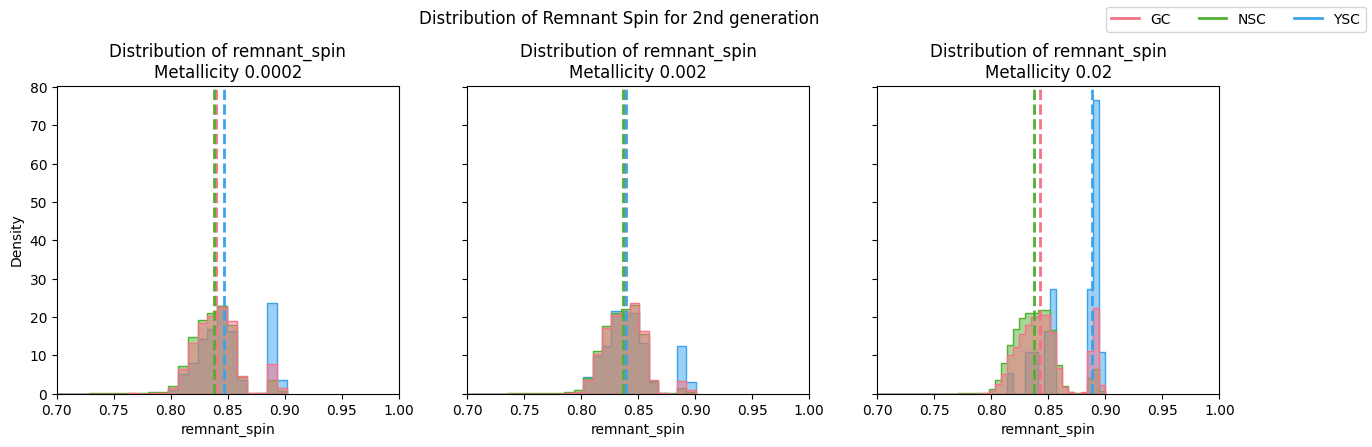

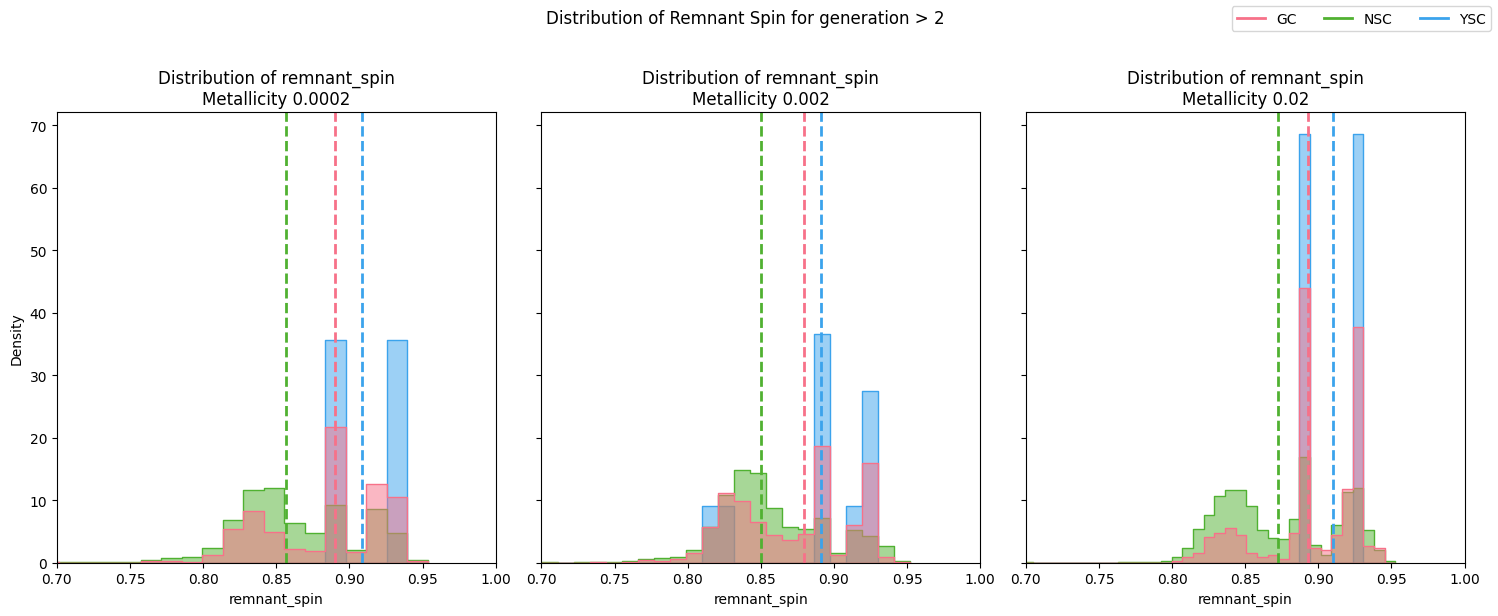

<Figure size 640x480 with 0 Axes>

Mean and Median Remnant Spin per Cluster (2nd generation):
 label  mean_remnant_spin  median_remnant_spin
     0           0.847181             0.842843
     1           0.838788             0.837646
     2           0.872477             0.888205

Mean and Median Remnant Spin per Cluster (generation > 2):
 label  mean_remnant_spin  median_remnant_spin
     0           0.896378             0.893192
     1           0.873719             0.872111
     2           0.910281             0.910281


In [7]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 6), sharey='row')

# Loop through each metallicity and each variable (remnant_spin)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for remnant_spin in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='remnant_spin', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of remnant_spin\nMetallicity {met}')
    axes[i].set_xlabel('remnant_spin')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_spin for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_rem_spin_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['remnant_spin'].median()
        axes[i].axvline(median_rem_spin_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for remnant_spin in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='remnant_spin', hue='label', bins=40, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of remnant_spin\nMetallicity {met}')
    axes2[i].set_xlabel('remnant_spin')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_spin for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_rem_spin_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['remnant_spin'].median()
        axes2[i].axvline(median_rem_spin_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Remnant Spin for 2nd generation', y=1.07)
#Add limits to x-axis
axes[0].set_xlim([0.7, 1])
axes[1].set_xlim([0.7, 1])
axes[2].set_xlim([0.7, 1])


# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Remnant Spin for generation > 2', y=1.02)
#Add limits to x-axis
axes2[0].set_xlim([0.7, 1])
axes2[1].set_xlim([0.7, 1])
axes2[2].set_xlim([0.7, 1])

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median remnant_spin for each cluster for 2nd generation
mean_median_rem_spin_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('remnant_spin').mean().alias('mean_remnant_spin'),
    pl.col('remnant_spin').median().alias('median_remnant_spin')
)

# Compute the mean and median remnant_spin for each cluster for generation > 2
mean_median_rem_spin_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('remnant_spin').mean().alias('mean_remnant_spin'),
    pl.col('remnant_spin').median().alias('median_remnant_spin')
)

# Display the mean and median remnant_spin per cluster for 2nd generation
print("Mean and Median Remnant Spin per Cluster (2nd generation):")
print(mean_median_rem_spin_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median remnant_spin per cluster for generation > 2
print()
print("Mean and Median Remnant Spin per Cluster (generation > 2):")
print(mean_median_rem_spin_per_cluster_gen_gt2.to_pandas().to_string(index=False))

## 4.5 Escape velocity distribution
The **escape velocity** represents a very important feature to distinguish between the different host bodies. In particular, since NSCs are very massive clusters, they are characterized by high values of escape velocities. GCs reach broader intermediate values, while YSCs have the lowest escape velocities. 

The same trend is found for both the systems of 2nd and $\gt$ 2nd-generation systems.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


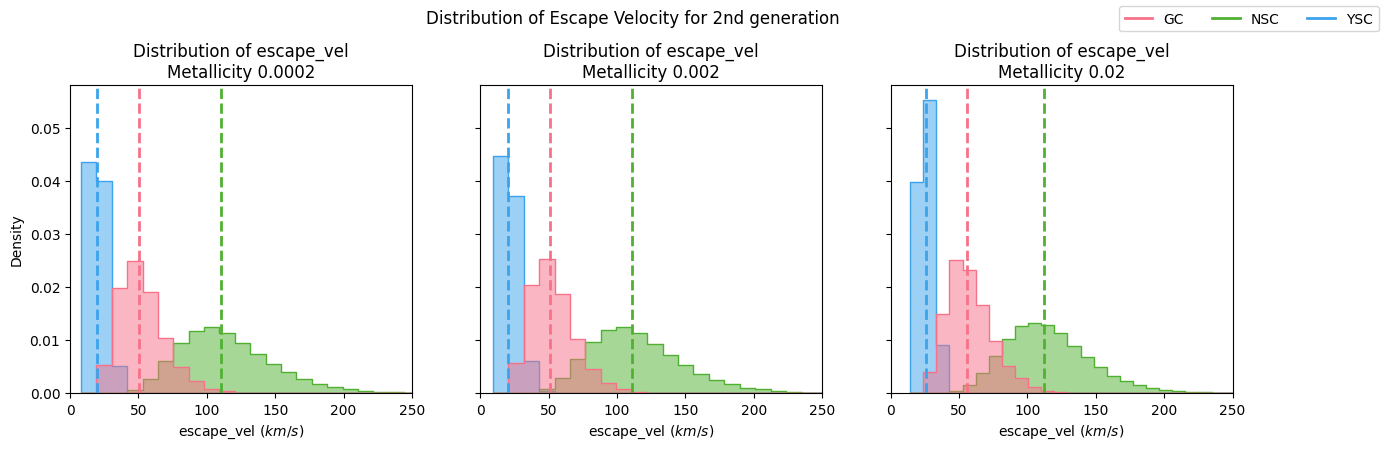

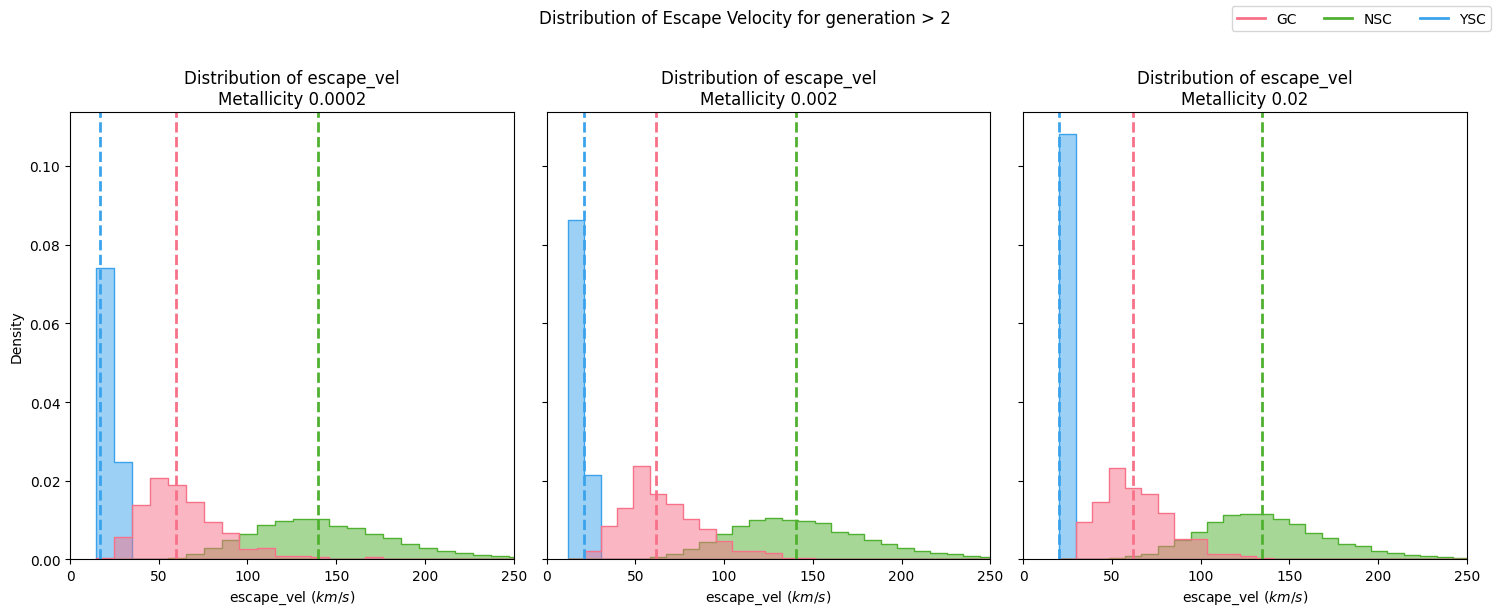

<Figure size 640x480 with 0 Axes>

Mean and Median Escape Velocity per Cluster (2nd generation):
 label  mean_escape_vel  median_escape_vel
     0        58.226328          55.689060
     1       115.785365         112.278647
     2        25.936919          25.659619

Mean and Median Escape Velocity per Cluster (generation > 2):
 label  mean_escape_vel  median_escape_vel
     0        63.906908          61.566995
     1       138.024412         134.331865
     2        20.375570          20.375570


In [8]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 6), sharey='row')

# Loop through each metallicity and each variable (escape_vel)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for escape_vel in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='escape_vel', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of escape_vel\nMetallicity {met}')
    axes[i].set_xlabel(r'escape_vel ($km/s$)')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in escape_vel for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_escape_vel_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['escape_vel'].median()
        axes[i].axvline(median_escape_vel_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for escape_vel in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='escape_vel', hue='label', bins=40, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of escape_vel\nMetallicity {met}')
    axes2[i].set_xlabel(r'escape_vel ($km/s$)')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in escape_vel for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_escape_vel_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['escape_vel'].median()
        axes2[i].axvline(median_escape_vel_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Escape Velocity for 2nd generation', y=1.07)
#Add limits to x-axis
axes[0].set_xlim([0, 250])
axes[1].set_xlim([0, 250])
axes[2].set_xlim([0, 250])

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Escape Velocity for generation > 2', y=1.02)
#Add limits to x-axis
axes2[0].set_xlim([0, 250])
axes2[1].set_xlim([0, 250])
axes2[2].set_xlim([0, 250])

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median escape_vel for each cluster for 2nd generation
mean_median_esc_vel_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('escape_vel').mean().alias('mean_escape_vel'),
    pl.col('escape_vel').median().alias('median_escape_vel')
)

# Compute the mean and median escape_vel for each cluster for generation > 2
mean_median_esc_vel_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('escape_vel').mean().alias('mean_escape_vel'),
    pl.col('escape_vel').median().alias('median_escape_vel')
)

# Display the mean and median escape_vel per cluster for 2nd generation
print("Mean and Median Escape Velocity per Cluster (2nd generation):")
print(mean_median_esc_vel_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median escape_vel per cluster for generation > 2
print()
print("Mean and Median Escape Velocity per Cluster (generation > 2):")
print(mean_median_esc_vel_per_cluster_gen_gt2.to_pandas().to_string(index=False))

## 4.6 Total mass distribution of the stellar cluster

The following plots show the distribution of the total mass of the cluster. The more massive clusters considered are the NSCs, reaching $10^7 M_\odot$. YSCs and GCs assest around lower values of the order of $10^6 M_\odot$.

The trend remains the same for both systems of 2nd and >2nd generation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


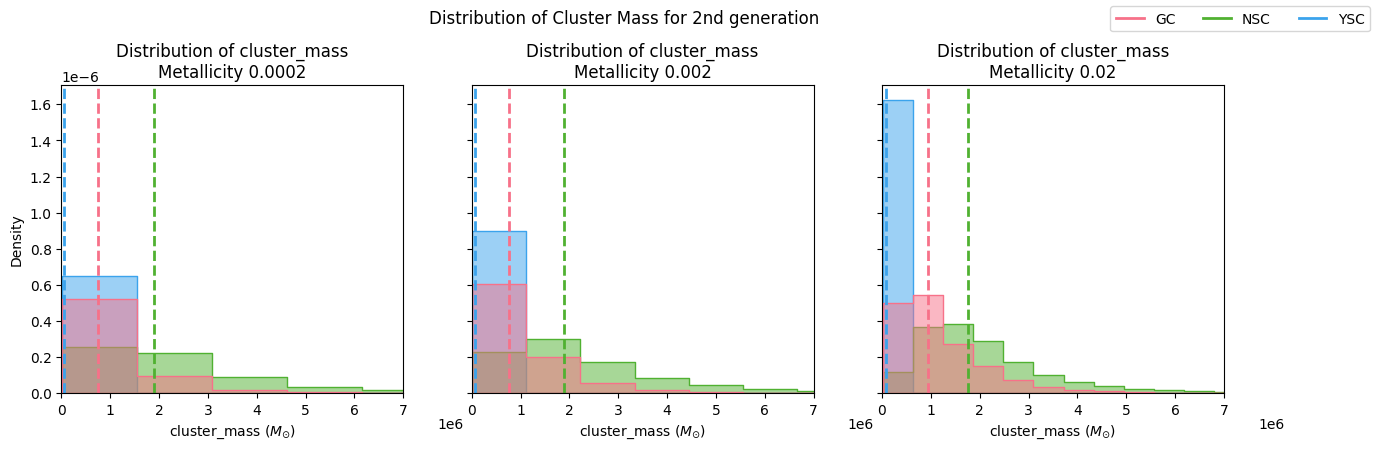

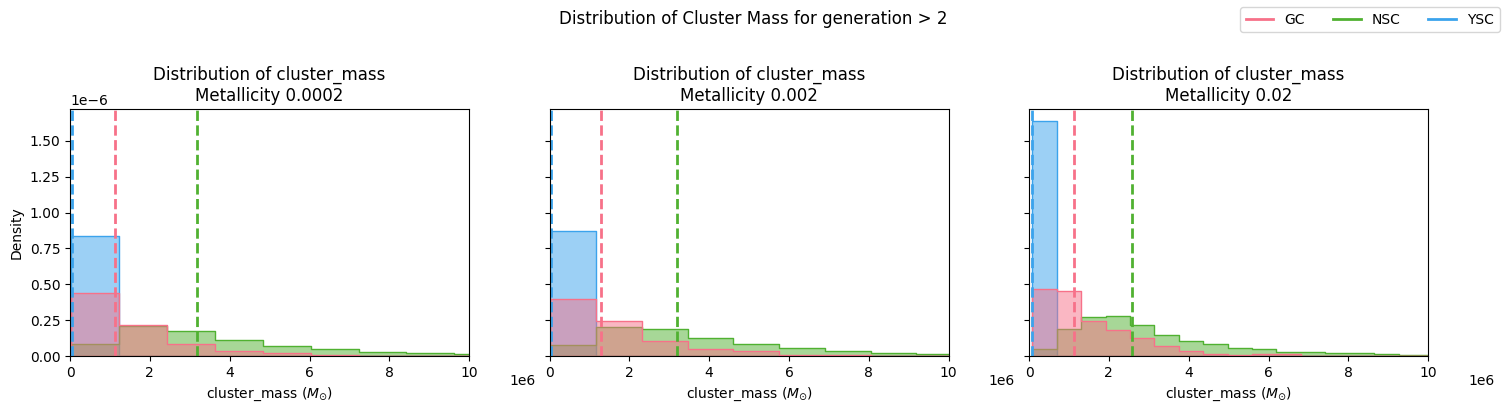

<Figure size 640x480 with 0 Axes>

Mean and Median Cluster Mass per Cluster (2nd generation):
 label  mean_cluster_mass  median_cluster_mass
     0       1.223025e+06         9.455763e+05
     1       2.132392e+06         1.766694e+06
     2       1.315934e+05         7.653570e+04

Mean and Median Cluster Mass per Cluster (generation > 2):
 label  mean_cluster_mass  median_cluster_mass
     0       1.538424e+06         1.117139e+06
     1       3.212142e+06         2.571705e+06
     2       8.108259e+04         8.108259e+04


In [9]:
# Function to format the x-axis labels to be in the order of 10^6
def format_func(value, tick_number):
    return "{:.0e}".format(value)

# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Loop through each metallicity and each variable (cluster_mass)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for cluster_mass in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='cluster_mass', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of cluster_mass\nMetallicity {met}')
    axes[i].set_xlabel(r'cluster_mass ($M_{\odot}$)')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in cluster_mass for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_cluster_mass_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['cluster_mass'].median()
        axes[i].axvline(median_cluster_mass_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Apply the x-axis label formatting for 2nd generation
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x / 1e6)))

    # Set x-axis limits for 2nd generation
    #axes[i].set_xlim(0, 2e7)
    axes[i].set_xlim([0, 7e6])

     # Add text annotation for order of magnitude in generation > 2
    axes[i].annotate("1e6", xy=(1.1, -0.1), xycoords="axes fraction", ha="left", va="center", fontsize=10)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for cluster_mass in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='cluster_mass', hue='label', bins=40, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of cluster_mass\nMetallicity {met}')
    axes2[i].set_xlabel(r'cluster_mass ($M_{\odot}$)')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in cluster_mass for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_cluster_mass_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['cluster_mass'].median()
        axes2[i].axvline(median_cluster_mass_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

    # Apply the x-axis label formatting for generation > 2
    axes2[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x / 1e6)))

    # Set x-axis limits for generation > 2
    axes2[i].set_xlim(0, 1e7)

    # Add text annotation for order of magnitude in generation > 2
    axes2[i].annotate("1e6", xy=(1.1, -0.1), xycoords="axes fraction", ha="left", va="center", fontsize=10)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Cluster Mass for 2nd generation', y=1.07)

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Cluster Mass for generation > 2', y=1.02)

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median cluster_mass for each cluster for 2nd generation
mean_median_cluster_mass_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('cluster_mass').mean().alias('mean_cluster_mass'),
    pl.col('cluster_mass').median().alias('median_cluster_mass')
)

# Compute the mean and median cluster_mass for each cluster for generation > 2
mean_median_cluster_mass_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('cluster_mass').mean().alias('mean_cluster_mass'),
    pl.col('cluster_mass').median().alias('median_cluster_mass')
)

# Display the mean and median cluster_mass per cluster for 2nd generation
print("Mean and Median Cluster Mass per Cluster (2nd generation):")
print(mean_median_cluster_mass_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median cluster_mass per cluster for generation > 2
print()
print("Mean and Median Cluster Mass per Cluster (generation > 2):")
print(mean_median_cluster_mass_per_cluster_gen_gt2.to_pandas().to_string(index=False))

## 4.7 Number of generations per hosting body

NSCs, because of their high escape velocity, allow a larger number of generations to form, up to primary masses over $\sim10^3 M_\odot$. The main limitation to building even more massive BHs in NSCs is represented by the long timescales: after ≈ 10 generations at most, the simulation reaches the Hubble time. In contrast, the maximum masses in both GCs and YSCs are
a few times $10^2 M_\odot$. Another crucial difference between NSCs and either GCs or YSCs is the fraction of nth- to first-generation mergers.

NSCs host up to 10 generations in the fiducial case (and up to 17 in the most optimistic case), while GCs and YSCs typically witness up to 4 − 5 and 3 − 4 generations, respectively.
In our case, GCs reach the 5th generation, while YSCs stop at the 3rd generation. This can be seen clearly thanks to the zooms on the distribution.

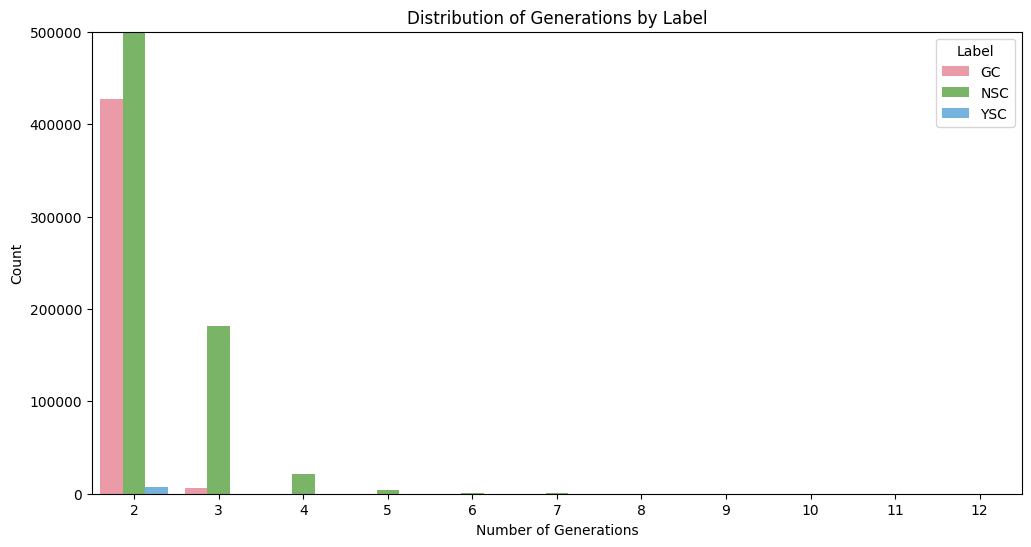

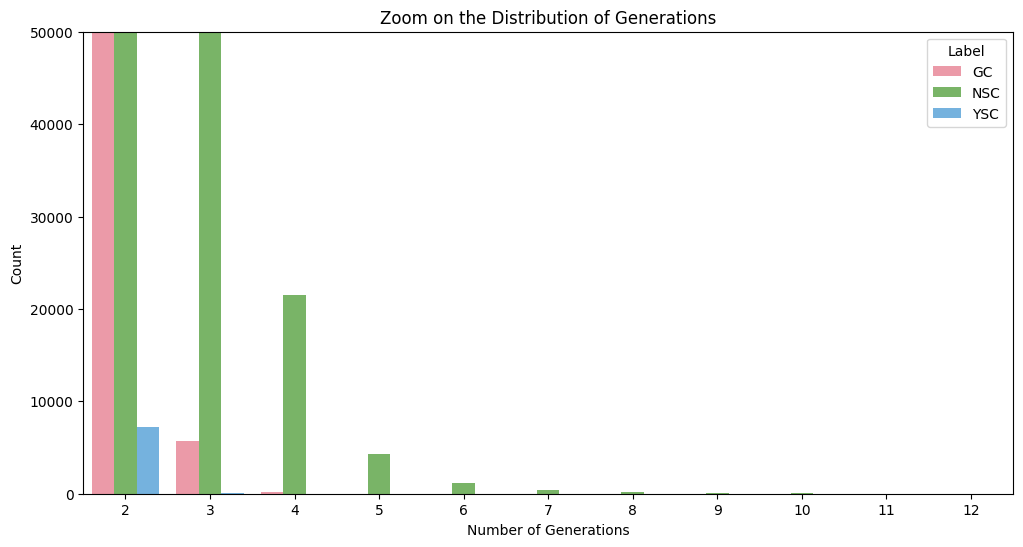

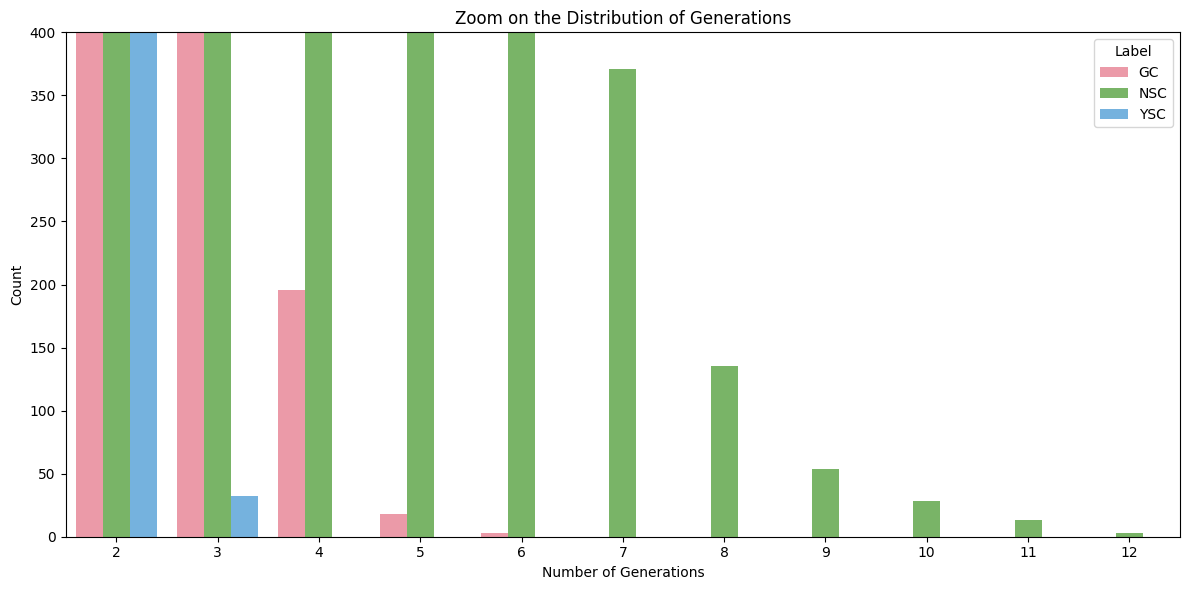

In [10]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

custom_palette = sns.color_palette("husl", n_colors=len(label_mapping))

# Create the first countplot with custom labels
plt.figure(figsize=(12, 6))
ax1 = sns.countplot(data=df.to_pandas(), x='n_gen', hue='label', palette=custom_palette, alpha=0.8)
ax1.set_xlabel('Number of Generations')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Generations by Label')
ax1.legend(title='Label', labels=label_mapping.values())


# Create the second countplot
plt.figure(figsize=(12, 6))
ax2 = sns.countplot(data=df.to_pandas(), x='n_gen', hue='label', palette=custom_palette, alpha=0.8)
ax2.set_xlabel('Number of Generations')
ax2.set_ylabel('Count')
ax2.set_title('Zoom on the Distribution of Generations')
ax2.legend(title='Label', labels=label_mapping.values())

# Create the third countplot
plt.figure(figsize=(12, 6))
ax3 = sns.countplot(data=df.to_pandas(), x='n_gen', hue='label', palette=custom_palette, alpha=0.8)
ax3.set_xlabel('Number of Generations')
ax3.set_ylabel('Count')
ax3.set_title('Zoom on the Distribution of Generations')
ax3.legend(title='Label', labels=label_mapping.values())

# Zoom in on the region 
ax1.set_ylim(0, 0.5e6)
ax2.set_ylim(0, 50_000)
ax3.set_ylim(0, 400)

# Show both plots
plt.tight_layout()
plt.show()

## 4.8 BH mass vs Escape velocity

We show the distribution of the masses of the primary and secondary BHs with respect to the escape velocity, one of the parameters designed as relevant in the previous analysis.

Similar behavior is experienced for the three different metallicities. The higher escape velocities associated with NSCs (in the range $100 \, \text{km/s} \lesssim \texttt{escape\_vel} \lesssim 400 \, \text{km/s}$) relate to higher BH masses (up to $500 \, M_\odot$). 

YSCs and GCs share lower velocities ($ < 100 \, \text{km/s}$). Regarding the masses, the range changes with the metallicity: higher metallicities are associated with lower masses. In general, for these two clusters, the masses are of the order of $100 \, M_\odot$.

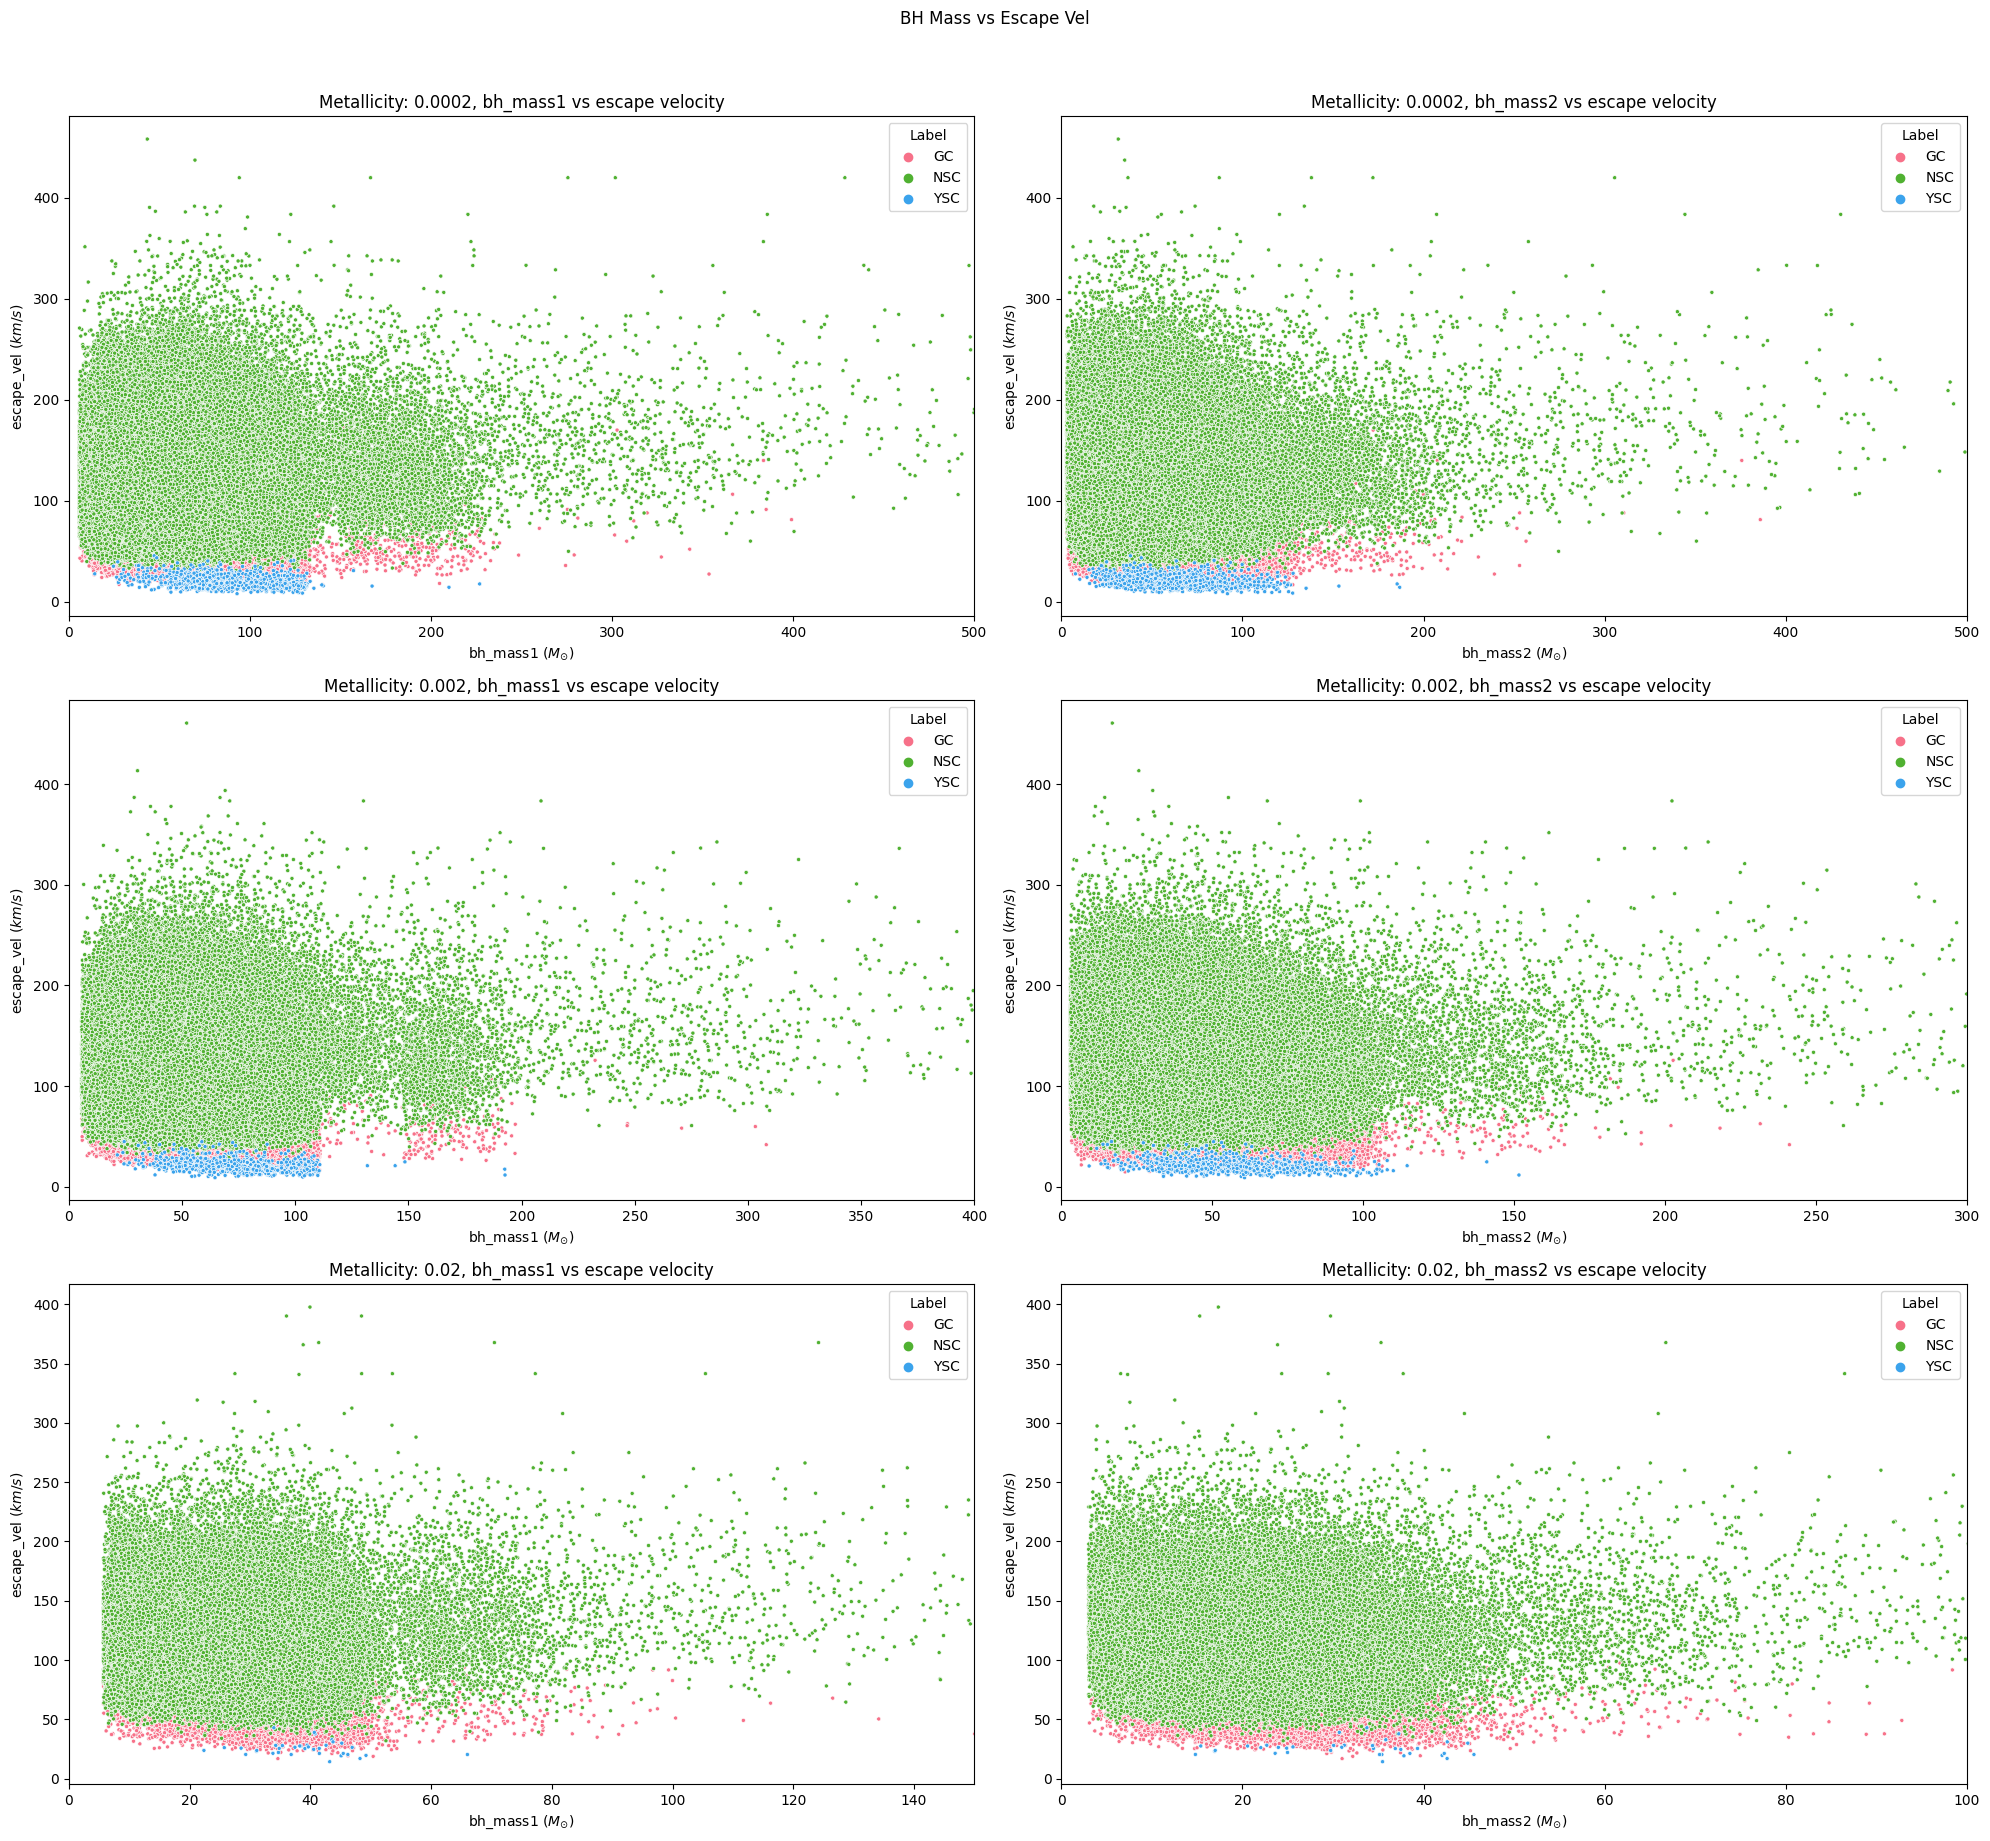

In [11]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

custom_palette = sns.color_palette("husl", n_colors=len(label_mapping))
# Convert selected_metallicities to float
selected_metallicities = [float(x) for x in ['0.0002', '0.002', '0.02']]

# Create a separate subplot for each metallicity
fig, axs = plt.subplots(len(selected_metallicities), 2, figsize=(20, 6 * len(selected_metallicities)))
 

for i, met in enumerate(selected_metallicities):
    # Filter df for the current metallicity
    df_met = df.filter(df['met'] == met)

    # Plot the primary bh masses vs escape velocity
    sns.scatterplot(data=df_met.to_pandas(), x='bh_mass1', y='escape_vel', hue='label', marker='.', linewidths=0.3, palette=custom_palette, ax=axs[i, 0])
    axs[i, 0].set_title(f'Metallicity: {met}, bh_mass1 vs escape velocity')
    axs[i, 0].set_xlabel(r'bh_mass1 ($M_{\odot}$)')
    axs[i, 0].set_ylabel(r'escape_vel ($km/s$)')
    axs[0, 0].set_xlim(0, 500) 
    axs[0,1].set_xlim(0, 500)
    axs[1, 0].set_xlim(0, 400)
    axs[1, 1].set_xlim(0, 300)
    axs[2, 0].set_xlim(0, 150)
    axs[2, 1].set_xlim(0, 100)
    

    # Plot the secondary bh masses vs escape velocity
    sns.scatterplot(data=df_met.to_pandas(), x='bh_mass2', y='escape_vel', hue='label', marker='.', linewidths=0.3, palette=custom_palette, ax=axs[i, 1])
    axs[i, 1].set_title(f'Metallicity: {met}, bh_mass2 vs escape velocity')
    
    # Add a custom legend
    handles, labels = axs[i, 0].get_legend_handles_labels()
    axs[i, 0].legend(handles, [label_mapping[label] for label in sorted(df_met['label'].unique())], title='Label')
    axs[i, 1].legend(handles, [label_mapping[label] for label in sorted(df_met['label'].unique())], title='Label')
    axs[i, 1].set_xlabel(r'bh_mass2 ($M_{\odot}$)')
    axs[i, 1].set_ylabel(r'escape_vel ($km/s$)')
    #Add title
    fig.suptitle('BH Mass vs Escape Vel', y=1.02)

plt.tight_layout()
plt.show()

## 4.9 BH remnant mass vs Metallicity

In the following plot, we can see which range of BH remnant masses is reached according to the metallicity and the cluster. NSCs show the higher masses to be concentrated at lower metallicities. YSCs have a similar trend for all metallicities, maintaining the values of the masses of the order of $10^2 M_\odot$. For GCs, the systems are almost equally distributed, reaching masses on average in the range of $200 \,  M_\odot \lesssim \texttt{remnant\_mass} \lesssim 600 \, M_\odot$.

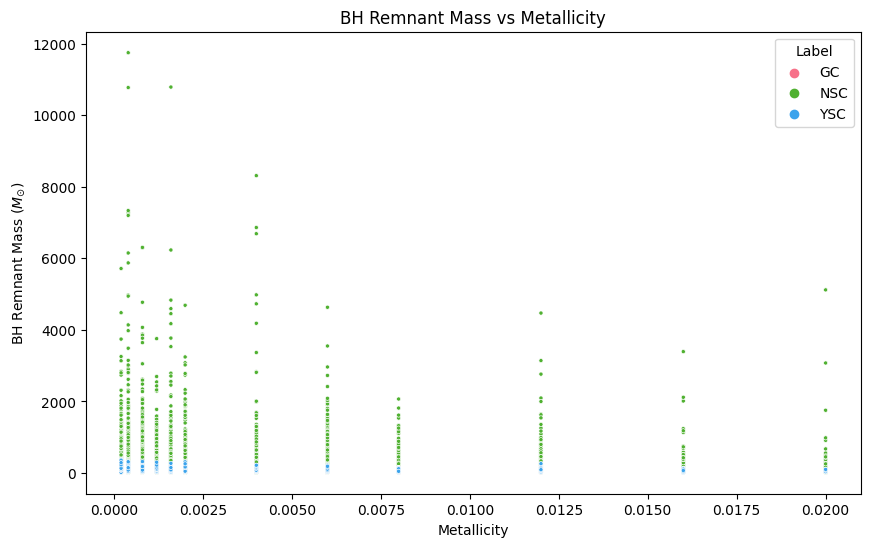

The palette list has more values (3) than needed (1), which may not be intended.


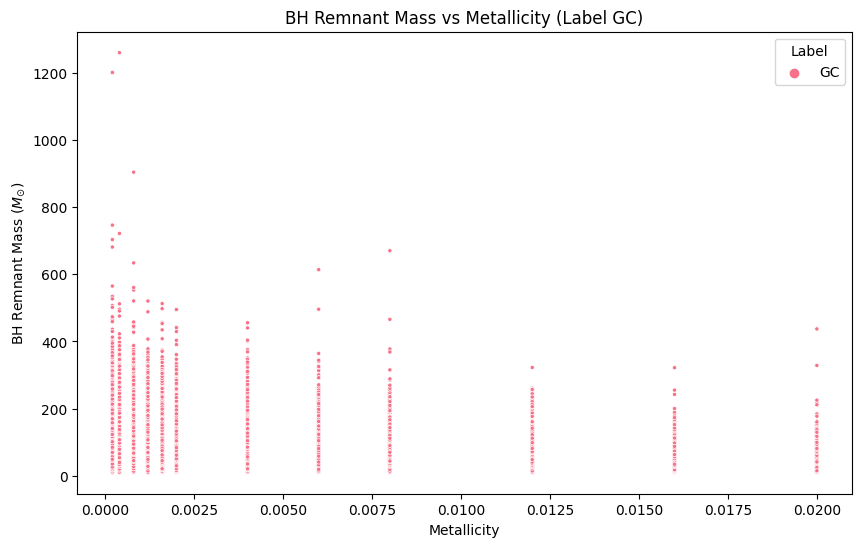

In [12]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

custom_palette = sns.color_palette("husl", n_colors=len(label_mapping))

# Scatterplot with a different color palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df.to_pandas(), x='met', y='remnant_mass', hue='label', marker='.', linewidths=0.3, palette=custom_palette, zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels
plt.title('BH Remnant Mass vs Metallicity')
plt.xlabel(r'Metallicity')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')

plt.show()

# Create a separate scatter plot for label 0
plt.figure(figsize=(10, 6))
# Filter the DataFrame for label == 0
df_label_0 = df.filter(df['label'] == 0)
sns.scatterplot(data=df_label_0.to_pandas(), x='met', y='remnant_mass', hue='label', marker='.', linewidths=0.3, palette=custom_palette, zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df_label_0['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels for the separate plot
plt.title('BH Remnant Mass vs Metallicity (Label GC)')
plt.xlabel(r'Metallicity')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')

plt.show()

## 4.10 BH remnant mass VS Escape velocity

In the following plots, we show the distribution of the BH remnant mass with respect to the escape velocity, distinguishing between the three hosting bodies.

NSCs are confirmed to have the higher escape velocities, producing the heaviest remnants (up to $4000 \, M_\odot$.) YSCs concentrate at low escape velocities ($< 100 \, km/s$) and reach masses $< 500 \, M_\odot$. Similar behavior can be found for the GCs: these systems have low escape velocities of the order of $10^2 \, km/s$, with the BH remnants reaching at most $\approx 10^3 M_\odot$.

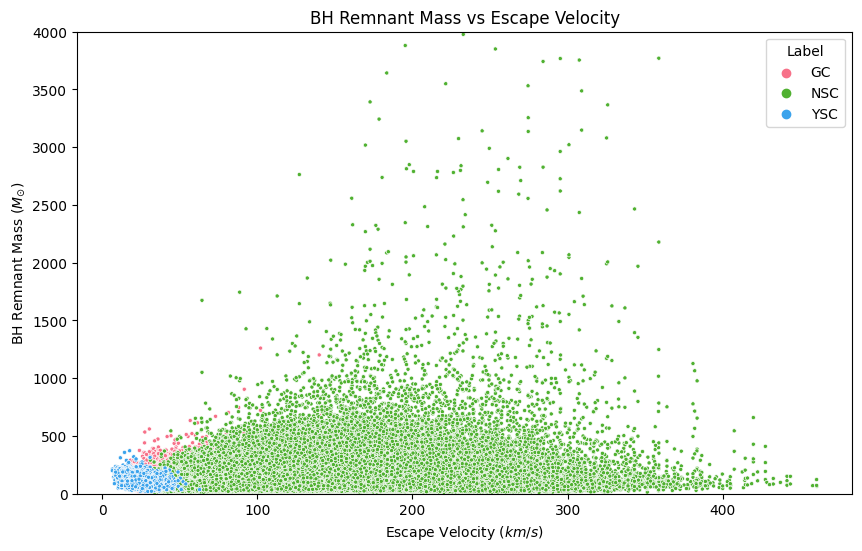

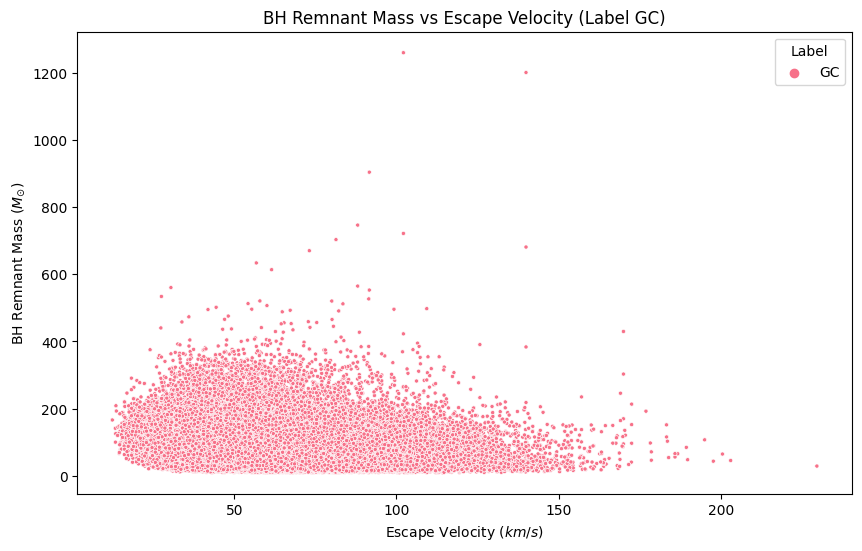

In [13]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

custom_palette = sns.color_palette("husl", n_colors=len(label_mapping))

# Scatterplot with a different color palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df.to_pandas(), x='escape_vel', y='remnant_mass', hue='label', marker='.', linewidths=0.3, palette=custom_palette, zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels
plt.title('BH Remnant Mass vs Escape Velocity')
plt.xlabel(r'Escape Velocity ($km/s$)')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')
plt.ylim(0, 4000)

plt.show()

label_mapping = {0: 'GC',}

custom_palette = sns.color_palette("husl", n_colors=len(label_mapping))

# Create a separate scatter plot for label 0
plt.figure(figsize=(10, 6))
# Filter the DataFrame for label == 0
df_label_0 = df.filter(df['label'] == 0)
sns.scatterplot(data=df_label_0.to_pandas(), x='escape_vel', y='remnant_mass', hue='label', marker='.', linewidths=0.3, palette=custom_palette, zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df_label_0['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels for the separate plot
plt.title('BH Remnant Mass vs Escape Velocity (Label GC)')
plt.xlabel(r'Escape Velocity ($km/s$)')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')

plt.show()

# 5. Classification analysis

In this section, we describe the machine learning tasks and their results.  

The reader must keep in mind that if they run the notebook cells again the values could be slightly different due to stochasticity, given by different functions used.

### 5.1 Data preprocessing

With `h.data_preprocessing` we prepare the dataset for the training and testing of the ML model.  
One important parameter is `balanced_label`. Having a balanced label dataset for a classifier. In our dataset, very few systems, w.r.t. other labels, belong to `label` = 2 (YSC). This is a problem if we restrict the dataset to fewer samples than the total (i.e. using the `n_sample` parameter). In fact, on the restricted dataset the models struggle to generalize over the label 2. So if we decide to restrict our dataset is mandatory to balance the labels (and the maximum number of samples will be label_2 $\times$ 3).

Here below we show what we said above. We train a simple Random Forest (RF) model three times: 
- Full dataset w/o balanced labels
- Restricted dataset w/o balanced labels
- Restricted dataset w/ balanced labels

There are several diagnostic tools to infer model performances. In our analysis, we use:  

**Accuracy**  
It measures the proportion of correctly classified instances out of the total instances. In other words, accuracy indicates the percentage of predictions that the model got right. Accuracy is commonly used when the classes in the dataset are balanced. It's a simple metric to evaluate overall model performance.  

**Confusion matrix**
The Confusion matrix summarizes the predictions made by the model on a dataset by comparing them to the actual labels. The matrix is organized into rows and columns, where each row represents the actual class labels and each column represents the predicted class labels. The main diagonal of the matrix shows the instances that were correctly classified, while the off-diagonal elements represent misclassifications.  

**ROC and AUC**  
The Receiver Operating Characteristic (ROC) curve and Area Under the ROC Curve (AUC) are used when classes are imbalanced or when you want to evaluate how well your model can distinguish between different classes.  
- A ROC curve is a graphical representation of the classifier's performance across various threshold settings. It plots the True Positive Rate (TPR), also called *recall*, against the False Positive Rate (FPR) at different classification thresholds, where $TPR = \frac{TP}{TP+FN}$ and $FPR = \frac{FP}{FP+TN}$.  
  A curve that hugs the top-left corner indicates a high TPR (recall) and low FPR, which are desirable. If the ROC curve deviates significantly from the diagonal, it suggests that the classifier is performing well.
- AUC represents the area under the ROC curve. It provides a single scalar value to summarize the classifier's performance across all possible thresholds. AUC ranges from 0 to 1, where a value of 1 indicates a perfect classifier and a value of 0.5 indicates a random classifier.  
  A higher AUC indicates that the classifier has better overall performance in distinguishing between classes.

##### 5.1.1 Full dataset w/o balanced labels

To run the simulation over the entire dataset it takes ~ 5 minutes. We achieve a pretty high accuracy on the test score, ~97%. But if we look at the confusion matrix, that tells us how the model had classified the samples, we see that ~50% of the label 2 are predicted as label 0. This is due to the fact that the label count of label 2 is 2 (3) order less than label 0 (1). The accuracy is high, but if we look at the AUC for label 2 we see that its value it's lower than the AUC for the remaining labels.  
The labels, in the complete dataset are unbalanced and lead to a bad generalization over unseen data.  

The same conclusions can be drawn for the `label_ngen` task, where the model struggles to classify the positive label (i.e. label 1).


Label count after sampling:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64

X_train shape: (2583317, 13)
X_test shape: (645830, 13)
y_train shape: (2583317,)
y_test shape: (645830,)

Training Score:        0.9979766323683853
Test score (Accuracy): 0.9710233343139836



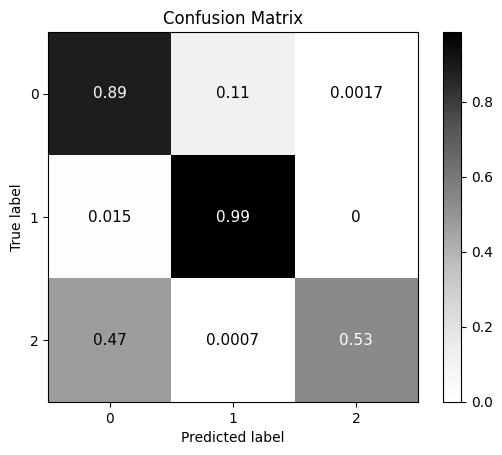

In [14]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance

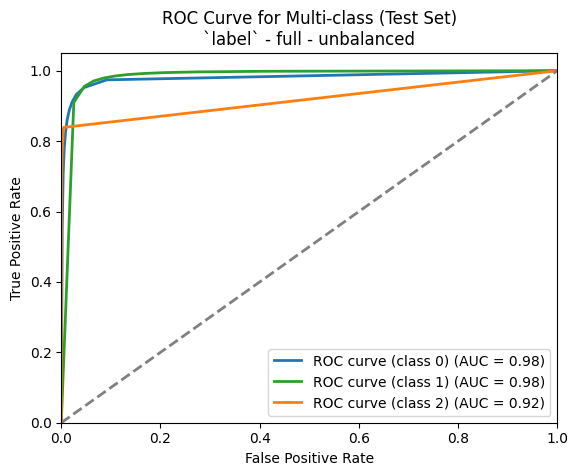

In [15]:
h.plot_ROC(RF, X_test, y_test, title='`label` - full - unbalanced')


Label count after sampling:
 0    2827812
1     401335
Name: label_ngen, dtype: int64

X_train shape: (2583317, 13)
X_test shape: (645830, 13)
y_train shape: (2583317,)
y_test shape: (645830,)



Training Score:        0.9890764470639879
Test score (Accuracy): 0.9407599523094313



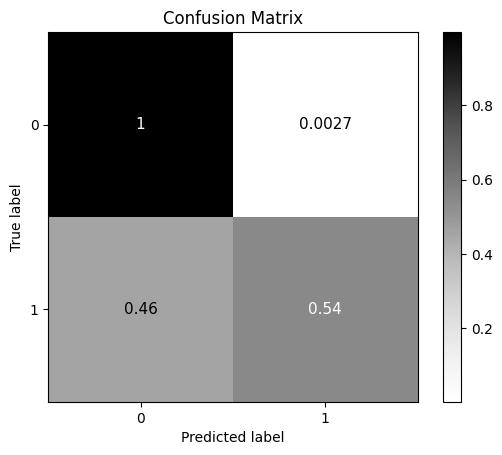

In [16]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label_ngen', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance

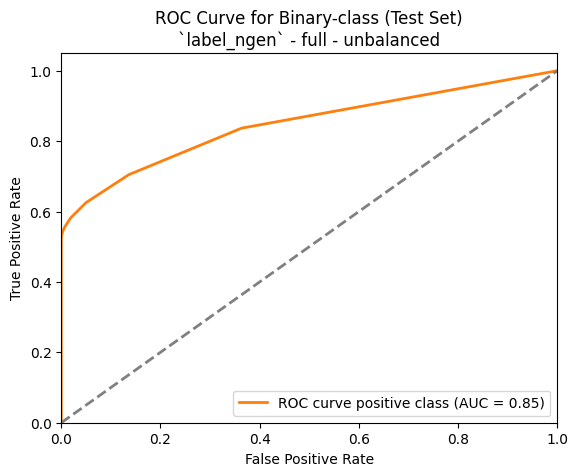

In [17]:
h.plot_ROC(RF, X_test, y_test, title='`label_ngen` - full - unbalanced')

##### 5.1.2 Restricted dataset w/o balanced labels
This time we take 100.000 samples, among all the labels, that correspond to ~3% of the dataset. The labels are unbalanced and we can notice that label 2 is still 2 (3) orders less than the other two labels. The results are similar as before.  

Again, with `label_ngen` task, we can see that label 0 is mislabeled ~50% of the time.  


The performance results are very similar to the ones above, so we can conclude that the dataset is still too unbalanced to guarantee an optimal classification.


Label count after sampling:
 1    86549
0    13240
2      211
Name: label, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.998
Test score (Accuracy): 0.9706



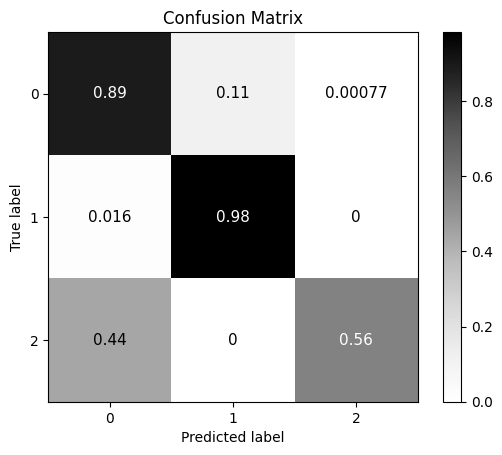

In [18]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance

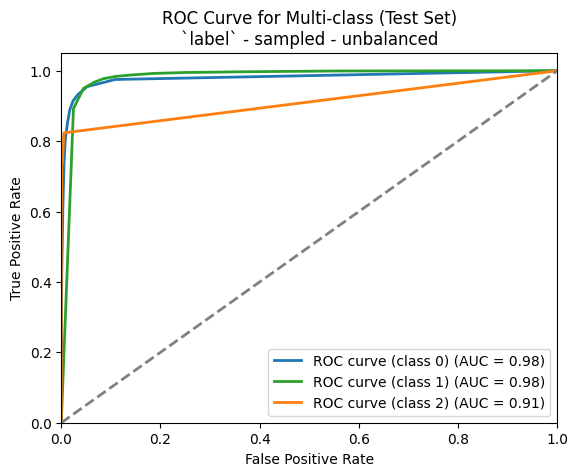

In [19]:
h.plot_ROC(RF, X_test, y_test, title='`label` - sampled - unbalanced')


Label count after sampling:
 0    87483
1    12517
Name: label_ngen, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.9889625
Test score (Accuracy): 0.93795



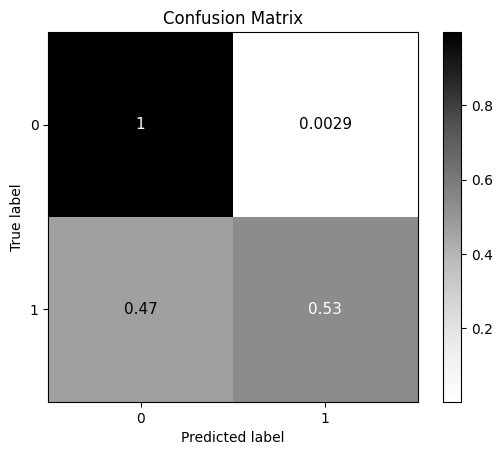

In [20]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)


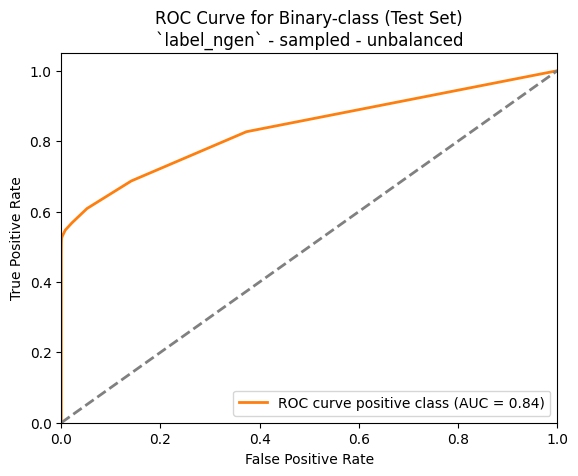

In [21]:
h.plot_ROC(RF, X_test, y_test, title='`label_ngen` - sampled - unbalanced')

##### 5.1.3 Restricted dataset w/ balanced labels

In this case, whether we downsample or not, the dataset will have $n_{sample} \le 7207\cdot3 = 21621$, which is ~0.66% of the complete dataset.  
This time, thanks to the balanced dataset, the labels are classified correctly with great accuracy ($\ge 88\,\%$). The test accuracy is la bit lower than the one in the benchmark above ($\sim 92\%$), but still a good result. The AUC is very close to 1, indicating that the model, even if it's SAP, is optimal to tackle this task.  

Regarding the classification problem with `label_ngen`, the dataset will have $n_{sample} \le 401335\cdot2 = 802670$, which is ~24% of the complete dataset. We can downsample the dataset to gain some computational speed. 
The test accuracy is around ~79% and the correct predictions are ~87% and ~71%, for 0 and 1. The AUC increased a little gaining a 3%.  
This is an acceptable result but we have to keep in mind that we are working with a simple model. In the section below we will see if a fine-tuned model can lower the number of misclassifications or if the problem is related to the dataset itself.


Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)

Training Score:        0.9943917668825162
Test score (Accuracy): 0.9197687861271676



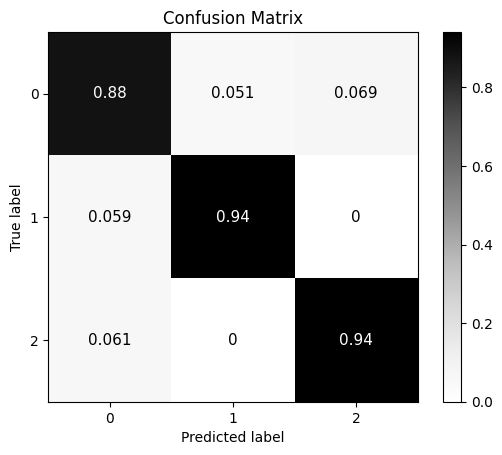

In [22]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)

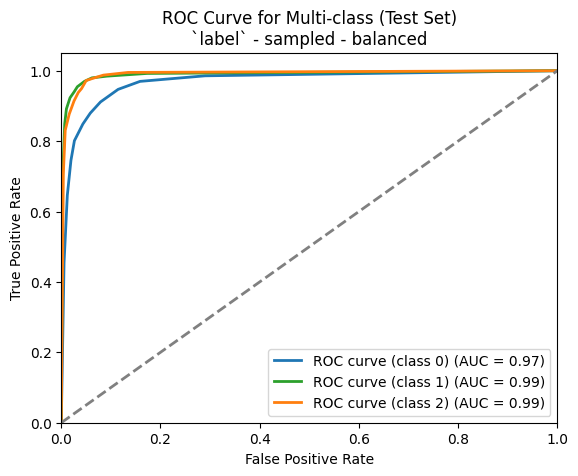

In [23]:
h.plot_ROC(RF, X_test, y_test, title='`label` - sampled - balanced')

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    50012
1    49988
Name: label_ngen, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)



Training Score:        0.9863875
Test score (Accuracy): 0.7919



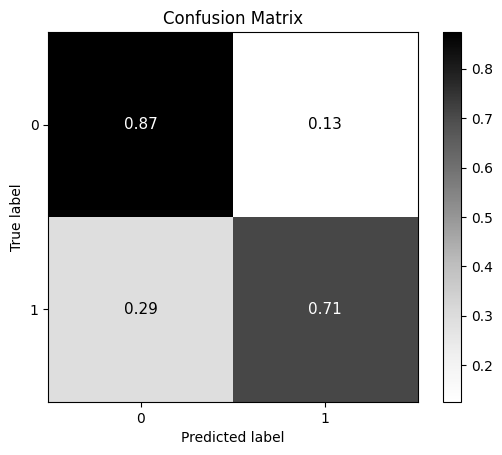

In [24]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)

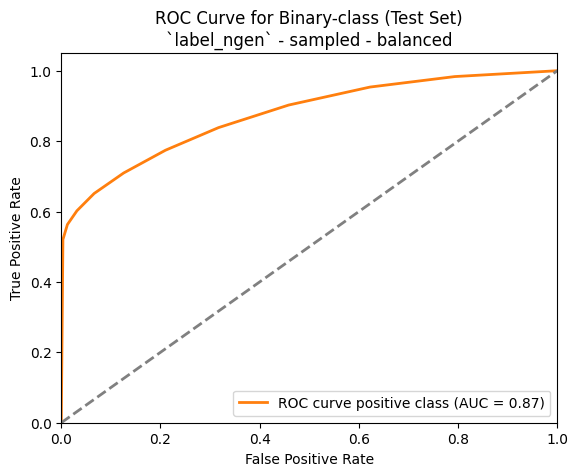

In [25]:
h.plot_ROC(RF, X_test, y_test, title='`label_ngen` - sampled - balanced')

We do not propose a similar analysis with `XGBoost` for brevity. The results are the same as for the RF.  
So, given the results above, we can conclude that the best way is to work with a balanced dataset in order to have a better generalization over unseen data, thus improving model evaluation.

We have also seen that we can reduce the number of samples while retaining a good accuracy score. The next step is to understand what is the optimal size of the sample dataset.

## 5.2 Best dataset size

In this section, we'll propose an analysis to understand which is the best sample size without losing too much accuracy. This is done to gain computational speed.  
We'll use `plot_learning_curve` function. This function takes in input the data that we want to analyze and the ML model. It uses the `sklearn` `learning_curve` function to calculate the mean training/test scores. The `sklearn` function divides the input data in the training set of different sizes.  
<!-- We can see that 14000 training samples provide a good result for the mean test score. So we can guess that the final model will have high accuracy if we use 18000 samples (that is a bit more than the sum of the training samples and the test samples, given the fact that we choose to use a test size of 20%).   -->
Similar tests are done with a simple XGB model and for `label_ngen`.

Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)


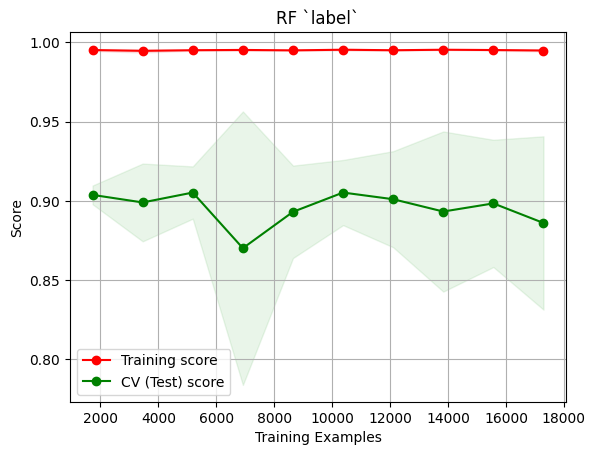

In [26]:
# RF
# `label` balanced dataset. Not downsampled

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=42) # simple RF model. The same used above

h.plot_learning_curve(RF, X, y, cv=5, title='RF `label`', train_sizes=np.linspace(0.1, 1.0, 10))

Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)


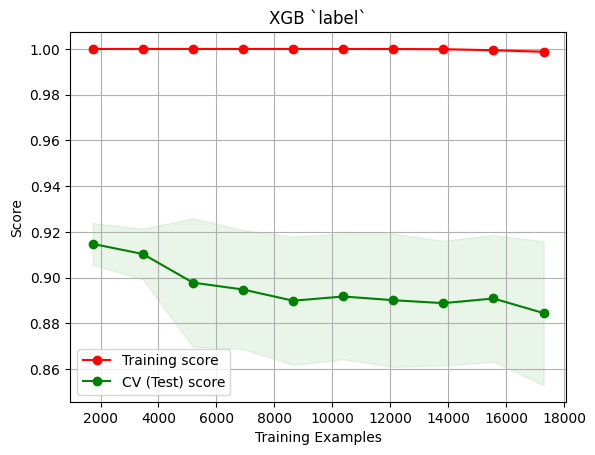

In [27]:
# XGB
# `label` balanced dataset. Not downsampled

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

XGB = XGBClassifier(random_state=42, tree_method='approx', n_jobs=4, **params,)

h.plot_learning_curve(XGB, X, y, cv=5, title='XGB `label`', train_sizes=np.linspace(0.1, 1.0, 10))

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    50012
1    49988
Name: label_ngen, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)


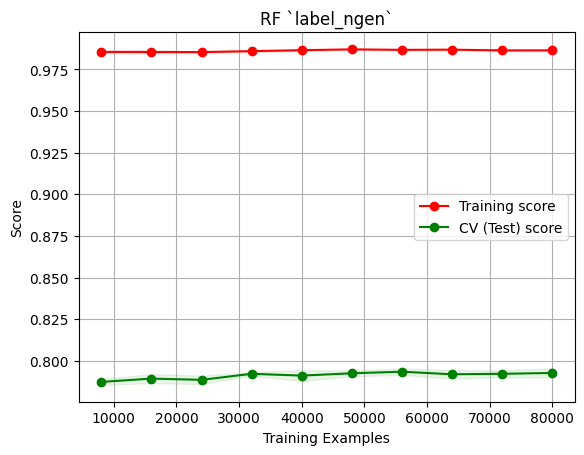

In [28]:
# RF
# `label_ngen` balanced dataset. 100_000 sample

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=42) # simple RF model. The same used above

h.plot_learning_curve(RF, X, y, cv=5, title='RF `label_ngen`', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=25)

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    50012
1    49988
Name: label_ngen, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)


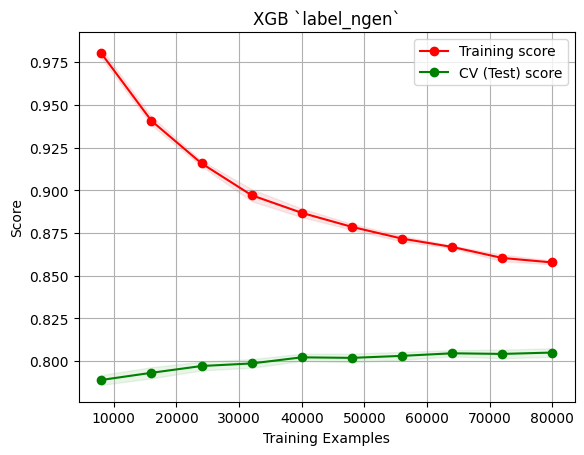

In [29]:
# XGB
# `label_ngen` balanced dataset. 100_000 sample

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

XGB = XGBClassifier(random_state=42, tree_method='approx', n_jobs=4, **params,)

h.plot_learning_curve(XGB, X, y, cv=5, title='XGB `label_ngen`', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=25)

### 5.2.1 Conclusion

These are the best values found from the test above. These are the samples count that will be used in the classification tasks.

- `label`:
  - RF: 
    - Tot samples: 13.750
    - Training samples: 11.000
    - Test samples: 2.750
  - XGB: 
    - Tot samples: 13.750
    - Training samples: 11.000
    - Test samples: 2.750
- `label_ngen`:
  - RF:
    - Tot samples: 37.500
    - Training samples: 30.000
    - Test samples: 7.500
  - XGB:
    - Tot samples: 31.250
    - Training samples: 25.000
    - Test samples: 6.250

## 5.3 Classification tasks

In this section, we will train two kinds of classifier: a Random Forest classifier and XGBoost classifier. Both models will be described in their respective subsections.  
Although the classification results are already great with a simple version of the models, we want to find the best combination of the most important hyperparameters in order to get the best results. We will use the `GridSearchCV` function from `sklearn`. Provided a grid of values, the function will test each combination of the provided hyperparameters and will return the best combination. This will be used to train and test the model, hereafter `RF_best` and `XGB_best`.  

We wanted to test the performance of two similar models, yet different, to have a broader choice before performing the features importance analysis. For each classification task, we will choose the model with the highest scores and use its result to analyze the features importance.  

<!-- The reader must to keep in mind that if he/she run the notebook cells again the values could be slightly different due to stocasticity, given by different functions used. -->

### 5.3.1 Random Forest Classifier

A random forest is a meta estimator that fits many decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.  
It builds multiple decision trees (hence the term "forest"), each based on a random subset of the training data and features. The randomness helps in creating diversity among the trees, reducing the risk of overfitting and improving the model's generalization. 
For classification tasks, each tree in the forest "votes" for a class, and the class with the most votes becomes the model's prediction and provides a measure of feature importance, indicating which features are most influential in making predictions. This can be helpful for feature selection and understanding the underlying relationships in the data.  

To complete those tasks we use the custom function `gridsearch_RF` that implements the `sklearn` `GridSearchCV` function.  
This time `model_evaluation` custom function will plot also the features importance histogram. We will use it in the next section. 

`gridsearch_scores` will show the training/test scores belonging to the best combination of the hyperparameters.

#### 5.3.1 a) `label` classification
We exclude the `cluster_mass` features because is an intrinsic feature of the host systems we want to try to classify based on BHs parameters.  
The best hyperparameter combination is `max_depth=15, min_samples_split=10, n_estimators=300`, where:
- max_depth: The maximum depth of the tree
- min_sample_split: The minimum number of samples required to split an internal node
- n_estimators: The number of trees in the forest

With this combination, the RF model reaches a test accuracy of ~93%. If we look at the confusion matrix we can see that $>= 88\%$ of the labels are correctly predicted. We can be satisfied with the model and the hyperparameters chosen through `GridSearchCV`.  

The results from the ROC are similar to the ones in Sec. 5.1.3, indicating that even the simplest model can tackle the classification w.r.t. `label`.

|**Score**| %|
|-----------|-------------------|
|Training score|97.4 %|
|Test score|92.7%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 88%           |
|1| 95%|
|2|95%|

Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 0    4615
2    4581
1    4554
Name: label, dtype: int64

X_train shape: (11000, 12)
X_test shape: (2750, 12)
y_train shape: (11000,)
y_test shape: (2750,)

Best parameters: 
 {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300} 

ID of the best combination: 
 17

Training Score:        0.9742727272727273
Test score (Accuracy): 0.9272727272727272



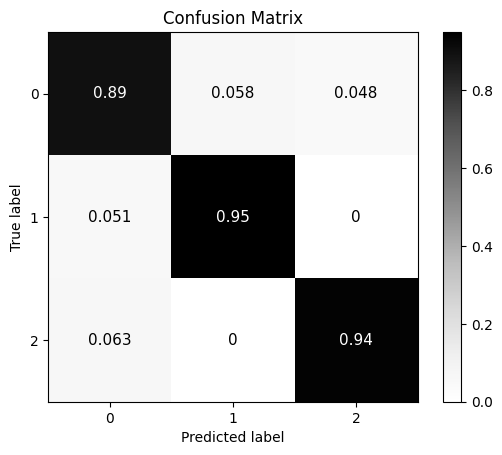

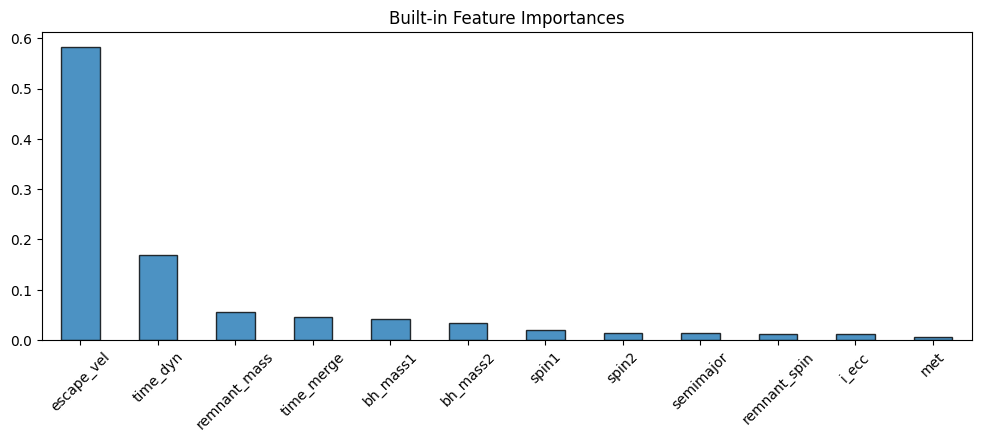

In [30]:
# Define the parameter grid
param_grid_lab_RF = {
    'n_estimators': [50, 100, 300,],
    'max_depth': [5, 15, 25],
    'min_samples_split': [5, 10, 15, 20]
}

df1 = df.clone()
df1 = df1.drop(['cluster_mass']) #clone df dataframe and drop the column cluster_mass

X_lab_RF, y_lab_RF, X_train_lab_RF, y_train_lab_RF, X_test_lab_RF, y_test_lab_RF = h.data_preprocessing(
    df1, n_sample=13_750, label='label', random_state=42, test_size=0.2, balanced_label=True)

RF_best_lab, y_pred_lab_RF, grid_search_lab_RF = h.gridsearch_RF(param_grid=param_grid_lab_RF, cv=3, 
                                                                 X_train=X_train_lab_RF, y_train=y_train_lab_RF, X_test=X_test_lab_RF, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(RF_best_lab, X_lab_RF, y_lab_RF, X_train_lab_RF, y_train_lab_RF, X_test_lab_RF, y_test_lab_RF, y_pred_lab_RF, bar_plot=True)

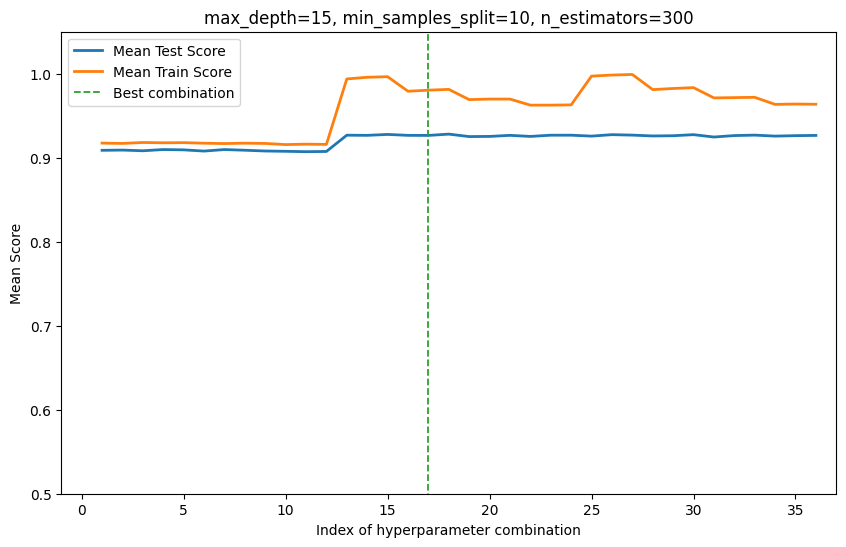

In [31]:
h.gridsearch_scores(grid_search_lab_RF)

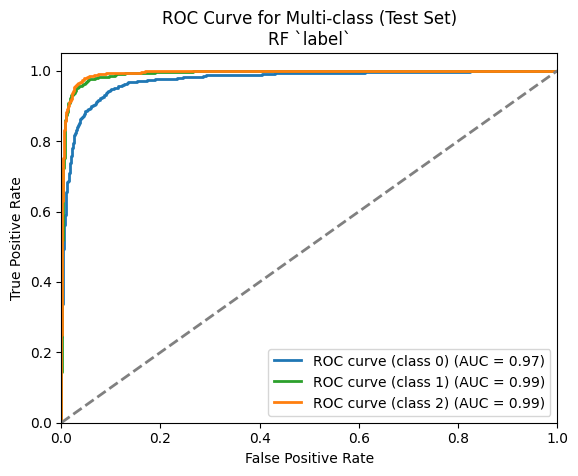

In [32]:
h.plot_ROC(RF_best_lab, X_test_lab_RF, y_test_lab_RF, title='RF `label`')

#### 5.3.1 b) `label_ngen` classification

The best hyperparameter combination is `max_depth=50, min_samples_split=100, n estimators=200`, where:
- max_depth: The maximum depth of the tree
- min_sample_split: The minimum number of samples required to split an internal node
- n_estimators: The number of trees in the forest

With this combination, the RF model reaches a test accuracy of ~80%. If we look at the confusion matrix we can see that the model struggles to classify correctly ~30% of label=1. Even with a fine-tuned model, there's little improvement.  
Looking at the AUC there's a little improvement of 3% w.r.t. the test with the simple model.  

We will try to understand if it is a problem related to the model or to the dataset itself.

| **Score**|% |                       
|-----------|-------------------| 
|Training score|85.0 %|
|Test score|80.8%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 87%           |
|1| 75%|

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    18770
1    18730
Name: label_ngen, dtype: int64

X_train shape: (30000, 13)
X_test shape: (7500, 13)
y_train shape: (30000,)
y_test shape: (7500,)

Best parameters: 
 {'max_depth': 50, 'min_samples_split': 100, 'n_estimators': 200} 

ID of the best combination: 
 6

Training Score:        0.8501333333333333
Test score (Accuracy): 0.8077333333333333



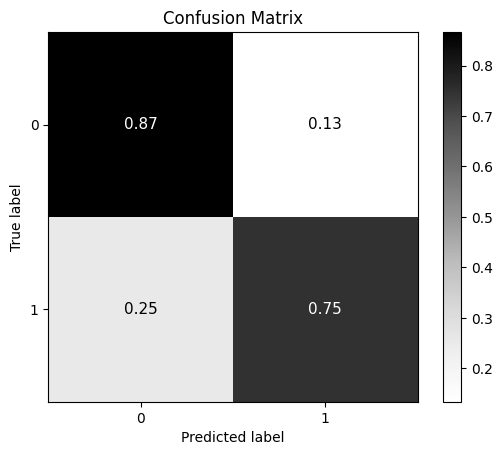

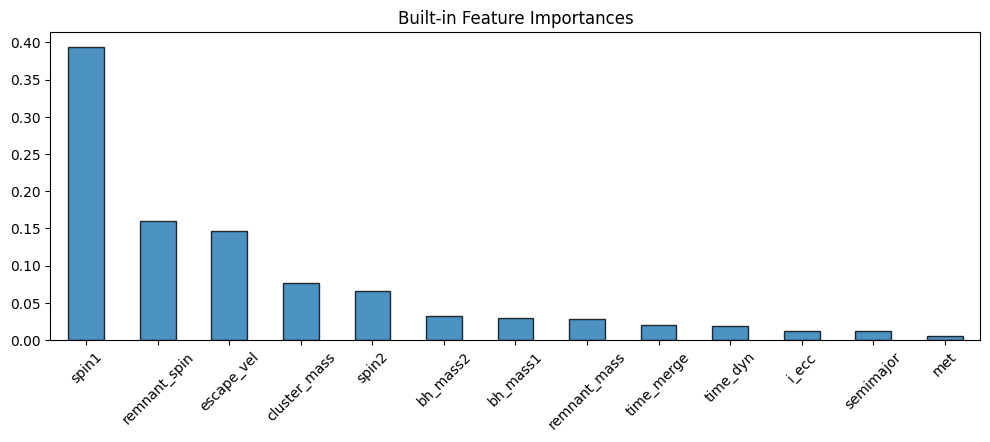

In [33]:
param_grid_ngen_RF = {
    'n_estimators': [200, 300],
    'max_depth': [50, 75, 100],
    'min_samples_split': [70, 80, 90, 100]
}

df1 = df.clone()

X_ngen_RF, y_ngen_RF, X_train_ngen_RF, y_train_ngen_RF, X_test_ngen_RF, y_test_ngen_RF = h.data_preprocessing(
    df1, n_sample=37_500, label='label_ngen', random_state=42, test_size=0.2, balanced_label=True)

RF_best_ngen, y_pred_ngen_RF, grid_search_ngen_RF = h.gridsearch_RF(param_grid=param_grid_ngen_RF, cv=3, 
                                                                 X_train=X_train_ngen_RF, y_train=y_train_ngen_RF, X_test=X_test_ngen_RF, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(RF_best_ngen, X_ngen_RF, y_ngen_RF, X_train_ngen_RF, 
                   y_train_ngen_RF, X_test_ngen_RF, y_test_ngen_RF, y_pred_ngen_RF, bar_plot=True)

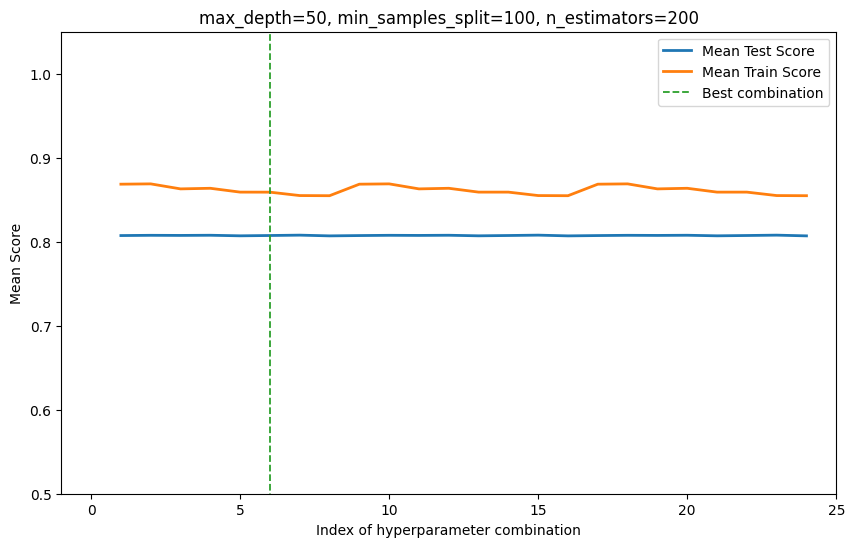

In [34]:
h.gridsearch_scores(grid_search_ngen_RF)

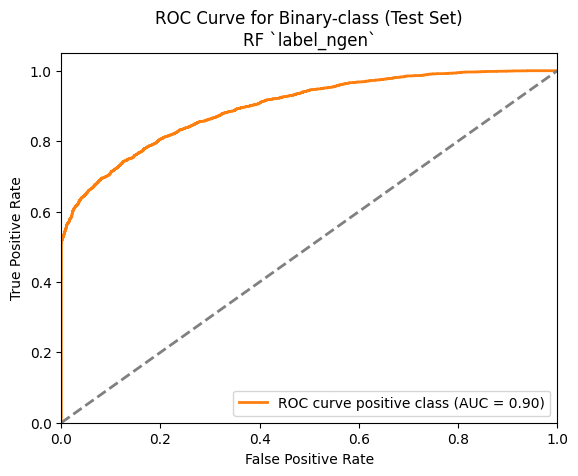

In [35]:
h.plot_ROC(RF_best_ngen, X_test_ngen_RF, y_test_ngen_RF, title='RF `label_ngen`')

### 5.3.2 XGBoost Classifier

XGBoostClassifier is an implementation of the XGBoost algorithm for classification tasks. XGBoost stands for Extreme Gradient Boosting, which is an advanced implementation of gradient boosting algorithms.  

XGBoostClassifier is based on the gradient boosting framework, which is an ensemble learning technique where multiple weak learners (typically decision trees) are combined to form a strong learner. It builds trees sequentially, where each subsequent tree corrects the errors made by the previous ones, thus gradually improving the overall model performance.  
XGBoost incorporates regularization techniques to prevent overfitting, such as L1 and L2 regularization on the leaf weights and tree complexity.  
Similar to RandomForestClassifier, XGBoostClassifier provides feature importance scores, allowing users to identify the most influential features in the model.

To complete those tasks we use the custom function `gridsearch_XGB` that implements the `sklearn` `GridSearchCV` function.  
This time `model_evaluation` custom function will plot also the features importance histogram. We will use it in the next section. 

`gridsearch_scores` will show the training/test scores belonging to the best combination of the hyperparameters.

#### 5.3.2 a) `label` classification

We exclude the `cluster_mass` features because is an intrinsic feature of the host systems we want to try to classify based on BHs parameters.  
The best hyperparameter combination is `colsample_bytree=0.5, gamma=O.2, learning_rate=0.2, max_depth=25, n estimators=150, reg_lambda=10, subsample=0.5`, where:
- colsample_bytree: Subsample ratio of columns when constructing each tree
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
- learning_rate: Step size shrinkage used in the update to prevent overfitting
- max_depth: The maximum depth of the tree
- n_estimators: The number of trees in the forest
- reg_lambda: L2 regularization term on weights
- subsample: Subsample ratio of the training instances

With this combination, the XGB model reaches a test accuracy of ~93%. If we look at the confusion matrix we can see that $>= 90\%$ of the labels are correctly predicted. We can be satisfied with the model and the hyperparameters chosen through `GridSearchCV`.
The training score equal 99.5% is an indication of slight overfitting: the model performs exceptionally well on the training data but fails to generalize completely unseen data.  
However, the ROC shows that `XGB_best_lab` is an optimal model.

|**Score** |% |                       
|-----------|-------------------| 
|----------------|-------|
|Training score | 99.5%|
|Test score| 92.8%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 90%           |
|1| 94%|
|2|94%|

Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 0    4615
2    4581
1    4554
Name: label, dtype: int64

X_train shape: (11000, 13)
X_test shape: (2750, 13)
y_train shape: (11000,)
y_test shape: (2750,)

Best parameters: 
 {'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 25, 'n_estimators': 150, 'reg_lambda': 10, 'subsample': 0.5} 

ID of the best combination: 
 127

Training Score:        0.9951818181818182
Test score (Accuracy): 0.9276363636363636



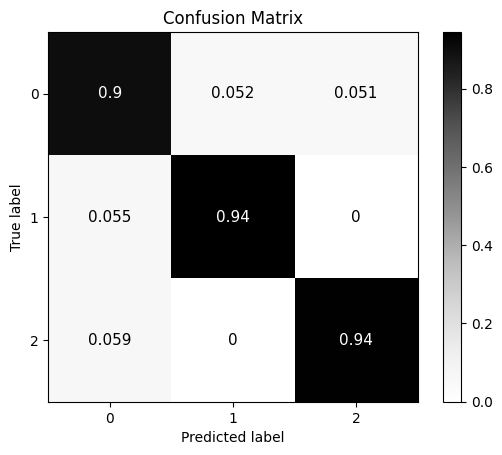

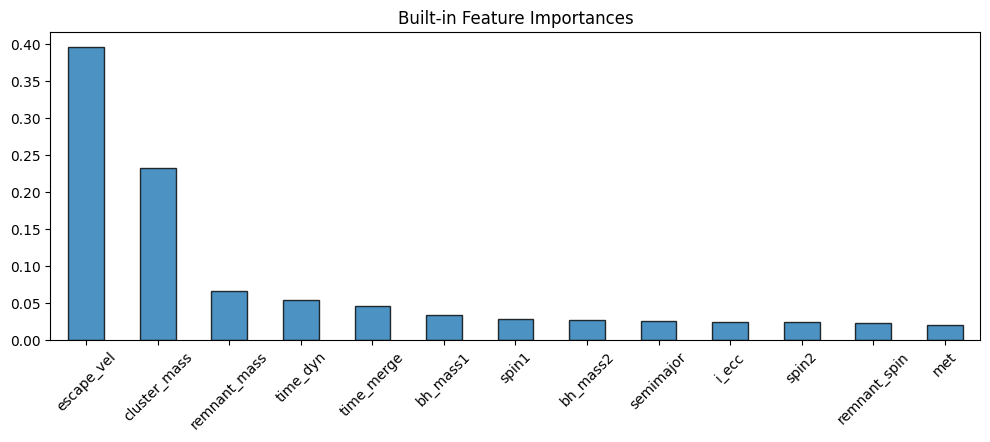

In [36]:
# Define the parameter grid
param_grid_lab_xgb = {
    'n_estimators': [100, 150, 200],    # Number of boosting rounds
    'max_depth': [25, 30],                # Maximum depth of each tree
    'learning_rate': [0.1, 0.2],           # Learning rate (shrinkage parameter)
    'subsample': [0.3, 0.5],                # Fraction of samples used for training each tree
    'colsample_bytree': [0.3, 0.5],         # Fraction of features used for training each tree
    'gamma': [0.2, 0.5],                      # Minimum loss reduction required to make a further partition on a leaf node
    #'reg_alpha': [0, 0.1, 0.2],                  # L1 regularization term on weights
    'reg_lambda': [5, 10],                 # L2 regularization term on weights
}

X_lab_xgb, y_lab_xgb, X_train_lab_xgb, y_train_lab_xgb, X_test_lab_xgb, y_test_lab_xgb = h.data_preprocessing(
    df, n_sample=13_750, label='label', random_state=42, test_size=0.2, balanced_label=True)

df1 = df.clone()
df1 = df1.drop(['cluster_mass'])

XGB_best_lab, y_pred_lab_xgb, grid_search_lab_xgb = h.gridsearch_XGB(param_grid=param_grid_lab_xgb, cv=3, 
                                                                 X_train=X_train_lab_xgb, y_train=y_train_lab_xgb, X_test=X_test_lab_xgb, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(XGB_best_lab, X_lab_xgb, y_lab_xgb, X_train_lab_xgb, 
                   y_train_lab_xgb, X_test_lab_xgb, y_test_lab_xgb, y_pred_lab_xgb, bar_plot=True)

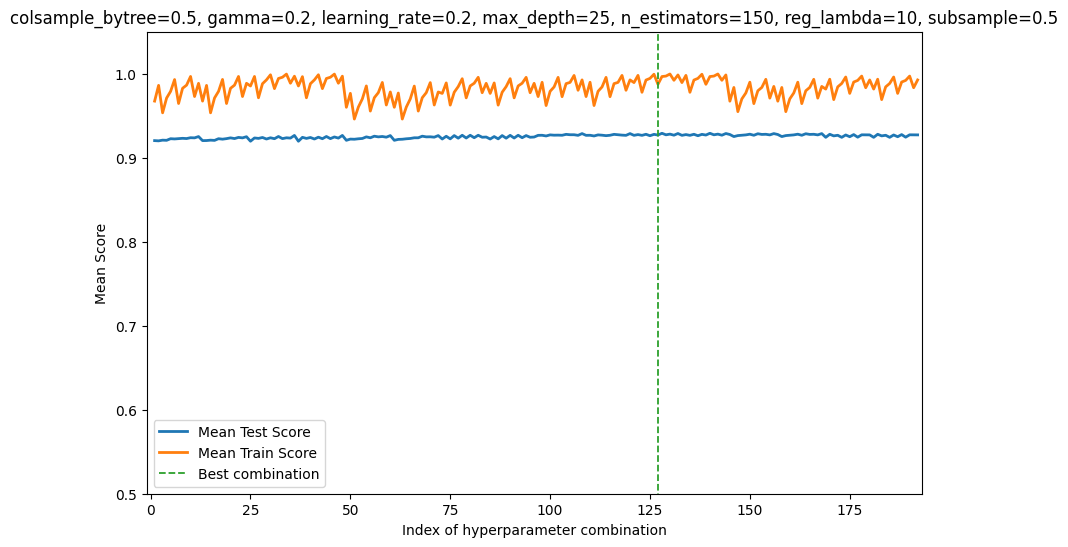

In [37]:
h.gridsearch_scores(grid_search_lab_xgb)

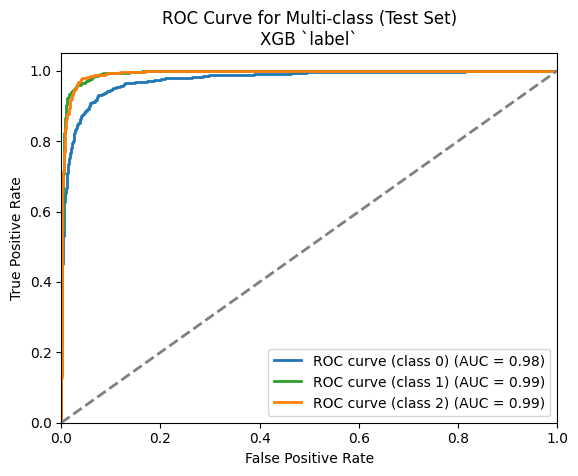

In [38]:
h.plot_ROC(XGB_best_lab, X_test_lab_xgb, y_test_lab_xgb, title='XGB `label`')

#### 5.3.2 b) `label_ngen` classification

The best hyperparameter combination is `colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=50, n estimators=200, reg_lambda=30, subsample=0.3`, where:
- colsample_bytree: Subsample ratio of columns when constructing each tree
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
- learning_rate: Step size shrinkage used in the update to prevent overfitting
- max_depth: The maximum depth of the tree
- n_estimators: The number of trees in the forest
- reg_lambda: L2 regularization term on weights
- subsample: Subsample ratio of the training instances

With this combination, the XGB model reaches a test accuracy of ~80%. In this case, the model seems not to overfit, however it still struggles to classify correctly ~25% of label=1. In addition to the RF model results, this could be an indication of a dataset-related problem. 

|**Score** |% |                       
|-----------|-------------------| 
|Training score | 86.8%|
|Test score| 80.0%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 87%           |
|1| 73%|

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    15702
1    15548
Name: label_ngen, dtype: int64

X_train shape: (25000, 13)
X_test shape: (6250, 13)
y_train shape: (25000,)
y_test shape: (6250,)

Best parameters: 
 {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 200, 'reg_lambda': 30, 'subsample': 0.3} 

ID of the best combination: 
 98

Training Score:        0.86836
Test score (Accuracy): 0.80016



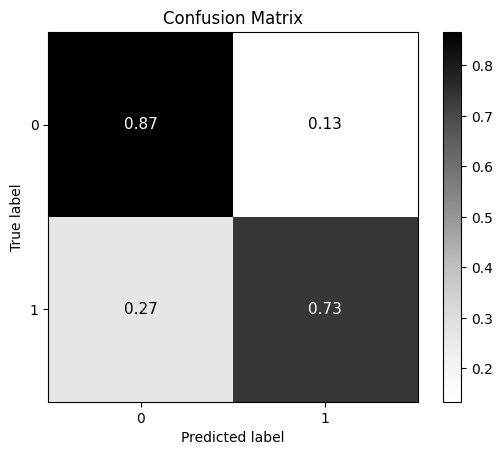

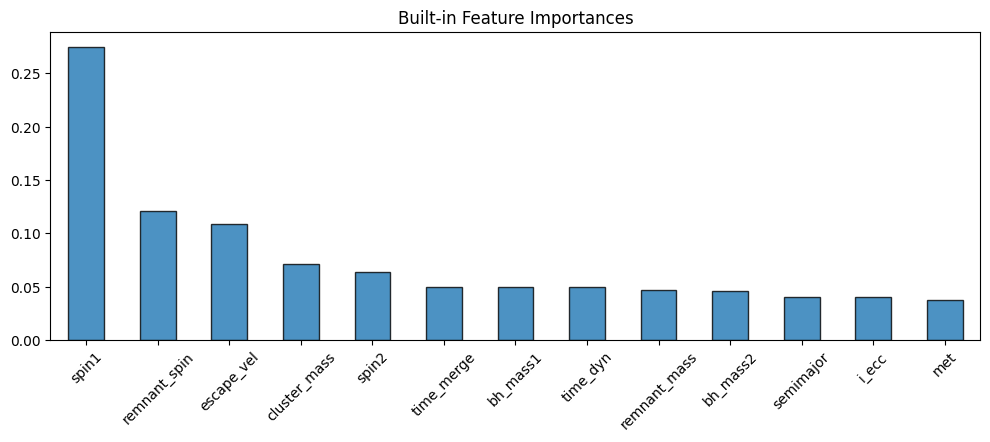

In [39]:
# Define the parameter grid
param_grid_ngen_xgb = {
    'n_estimators': [200, 300],    # Number of boosting rounds
    'max_depth': [50, 75, 100],                # Maximum depth of each tree
    'learning_rate': [0.1, 0.2],           # Learning rate (shrinkage parameter)
    'subsample': [0.3, 0.5],                # Fraction of samples used for training each tree
    'colsample_bytree': [0.3, 0.5],         # Fraction of features used for training each tree
    'gamma': [0.5, 0.8],                      # Minimum loss reduction required to make a further partition on a leaf node
    # 'reg_alpha': [10, 20],                  # L1 regularization term on weights
    'reg_lambda': [20, 30],                 # L2 regularization term on weights
    #'min_child_weight': [1, 3, 5],               # Minimum sum of instance weight needed in a child
}

X_ngen_xgb, y_ngen_xgb, X_train_ngen_xgb, y_train_ngen_xgb, X_test_ngen_xgb, y_test_ngen_xgb = h.data_preprocessing(
    df, n_sample=31_250, label='label_ngen', random_state=42, test_size=0.2, balanced_label=True)

XGB_best_ngen, y_pred_ngen_xgb, grid_search_ngen_xgb = h.gridsearch_XGB(param_grid=param_grid_ngen_xgb, cv=3, 
                                                                 X_train=X_train_ngen_xgb, y_train=y_train_ngen_xgb, X_test=X_test_ngen_xgb, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(XGB_best_ngen, X_ngen_xgb, y_ngen_xgb, X_train_ngen_xgb, 
                   y_train_ngen_xgb, X_test_ngen_xgb, y_test_ngen_xgb, y_pred_ngen_xgb, bar_plot=True)

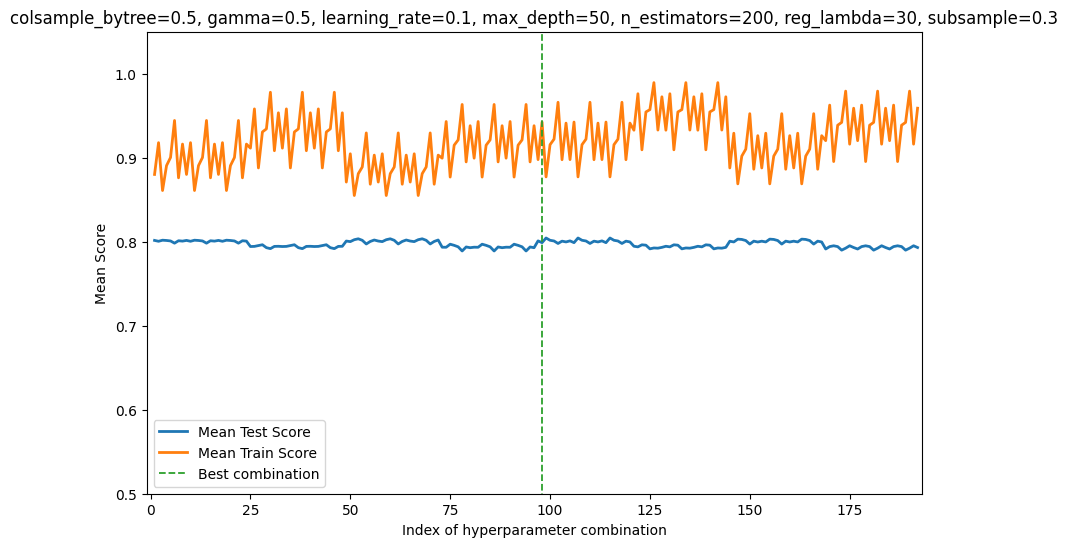

In [40]:
h.gridsearch_scores(grid_search_ngen_xgb)

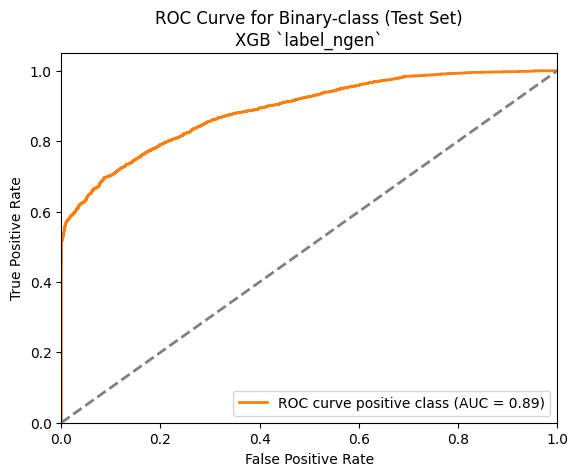

In [41]:
h.plot_ROC(XGB_best_ngen, X_test_ngen_xgb, y_test_ngen_xgb, title='XGB `label_ngen`')

### 5.3.3 Discussion

- `label`: Both models have optimal training and test accuracy. While the AUC scores are better for `XGB_best_lab`, it might be affected by a slight overfitting. The label prediction is similar and optimal.

- `label_ngen`: Two different models struggle to classify approximately 25%/30% of label `1`, despite the dataset being balanced and the models not exhibiting strong overfitting. There could be several reasons for this behavior:
  - **Inherent Complexity of the Data**: the data might contain patterns that are inherently difficult to capture. Certain data distributions or relationships could be challenging for the models to learn;
  -  Even though the classes are balanced overall, there might be **specific subgroups** within the classes that are imbalanced, and the models might struggle to capture patterns within these subgroups;
  -  It's possible that the models used are **too complex** or **too simple** for the given task.
  
Since both models have similar results, we choose to use in the feature analysis the RandomForestClassifier model `RF_best_*`, because it is less complex and easier (i.e. faster) to train.

# 6. Features importance analysis


We split our features importance analysis into two parts for the two different tasks:
 - `label`: Feature importance analysis will tell us which features are most important to understand which system belongs to which host stellar cluster
 - `label_ngen`: Feature importance analysis will tell us which features are most important that lead systems to evolve and which do not

To do so we will visually inspect the results from the SHAP analysis (explained in the next sub-section). `shap_explainer` takes in input the trained model and the background data that we want to integrate (i.e. analyze to understand features importance w.r.t. those data). The parameter `n_sample` is optional. It refers to the number of samples to select. Since the model is already trained, anywhere from 100 to 1000 random background samples are good sizes to use.  
Once the SHAP values are calculated we can plot those values in 2 different kinds of plots, using two custom functions: `plot_shap_bar` and
`plot_shap_violin`. The meaning of the plots is explained in the next subsection.

## 6.1 SHAP values

[SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values are a method used to explain the predictions of machine learning models. They were introduced by [Lundberg and Lee](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) in 2017 and are based on cooperative game theory.

SHAP values provide a way to allocate the contribution of each feature in a prediction model to the final prediction. They aim to quantify the impact of each feature on the prediction outcome by considering all possible combinations of features and calculating the contribution of each feature in each combination.

The core idea behind SHAP values is the concept of [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), which is a method for fairly distributing the payout of a cooperative game among the players based on their individual contributions. In the context of machine learning models, the features are treated as players, and the prediction outcome is the payout.

To calculate SHAP values, a baseline reference is established, which serves as a starting point for the feature contributions. Then, different combinations of features are created, and for each combination, the model predictions are observed. The contribution of each feature is determined by comparing the predictions with and without the feature included.

SHAP values provide several advantages in interpreting machine learning models. They offer a unified framework for feature importance measurement that is both consistent and locally accurate. They also satisfy desirable properties such as consistency, meaning that if a feature is removed or added, the SHAP values change accordingly. Furthermore, SHAP values can be used to explain individual predictions as well as provide an overview of feature importance across the entire dataset.

In our study, we employed three types of visualizations to gain insights into the importance of each feature*.

**Summary plot (bar type) for global inspection**  
This kind of plot examines the mean absolute SHAP value for each feature across all of the data. This quantifies, on average, the magnitude of each feature's contribution towards the predicted label. If a feature has a high mean SHAP value, it suggests that it generally has a strong influence on the predictions. Conversely, a low mean SHAP value indicates that the feature has less impact on the model's predictions. Mean absolute SHAP values are essentially a drop-in replacement for more traditional feature importance measures but have two key advantages:

- Mean absolute SHAP values are more theoretically rigorous, and relate to which features impact predictions most. Conventional feature importances are measured in more abstract and algorithm-specific ways and are determined by how much each feature improves the model's predictive performance.
- Mean absolute SHAP values have intuitive units, like the target variable. Feature importances are often expressed in counterintuitive units based on complex concepts such as tree algorithm node impurities.
The features are presented in descending order of importance, with the most significant feature listed at the top and the less significant features listed towards the bottom.

**Summary plot (bar type) for label inspection**  
We created separate plots for each label to gain a more accurate understanding of the feature importance. By examining the importance of features for each label individually, we obtained specific insights into their contributions to the prediction accuracy for each class.

**Summary plot (violin type) for each label (evolution channel)**  
This is the most useful type of plot for our study. A SHAP violin plot provides a visual representation of the distribution of SHAP values for different features in the model. It helps in understanding the impact of each feature on the model's predictions.

- Vertical Axis: The vertical axis represents the features in the model. The features are presented in descending order of importance.

- Horizontal Axis: The horizontal axis represents the range of SHAP values. It spans from negative to positive values, indicating the direction and magnitude of the feature's influence on the predictions.

- Violin Shape: Each violin-shaped distribution represents the density of the SHAP values for a specific feature. The width of the violin at a given point represents the density or frequency of SHAP values at that point.

  - A wider section of the violin indicates a higher density of SHAP values, indicating a stronger influence of the feature on the predictions.
  - A narrower section of the violin indicates a lower density of SHAP values, suggesting a weaker influence.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

The SHAP violin plot allows you to compare the distributions of SHAP values across different features. It helps identify features that have consistent and impactful contributions (wider violins with higher densities) and those that have less influence (narrower violins with lower densities).

The plot can also reveal features with bimodal or asymmetric distributions, indicating the presence of different subgroups or distinct patterns in the data that affect the predictions differently.

* ref1: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* ref2: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

## 6.2 `label` features importance
For this task, we will try to give an astrophysical explanation, although the model correctly classified the systems we cannot provide a precise explanation for all the features.  

We will focus on the top 5 features, either for brevity and for the fact that they retain almost the totality of the features importance.

In [42]:
lab_shap_values = h.shap_explainer(RF_best_lab, X_test_lab_RF, n_sample=None) # calculate shap values. We want to explain test data

### 6.2.1 Summary plot (bar type)

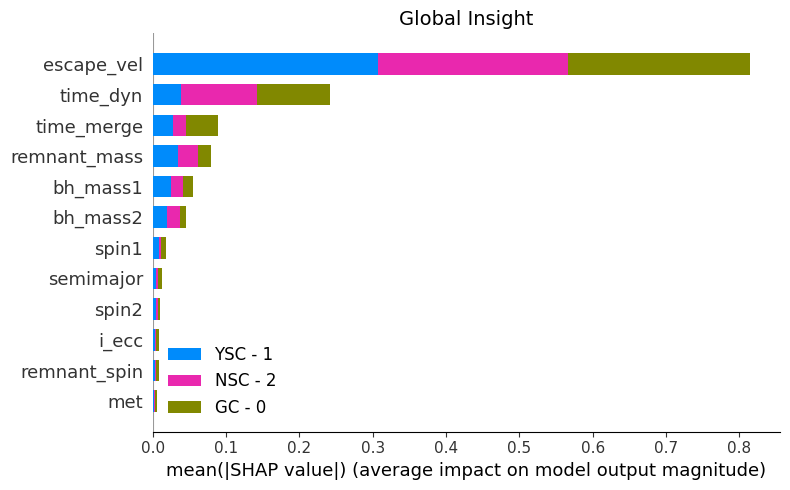

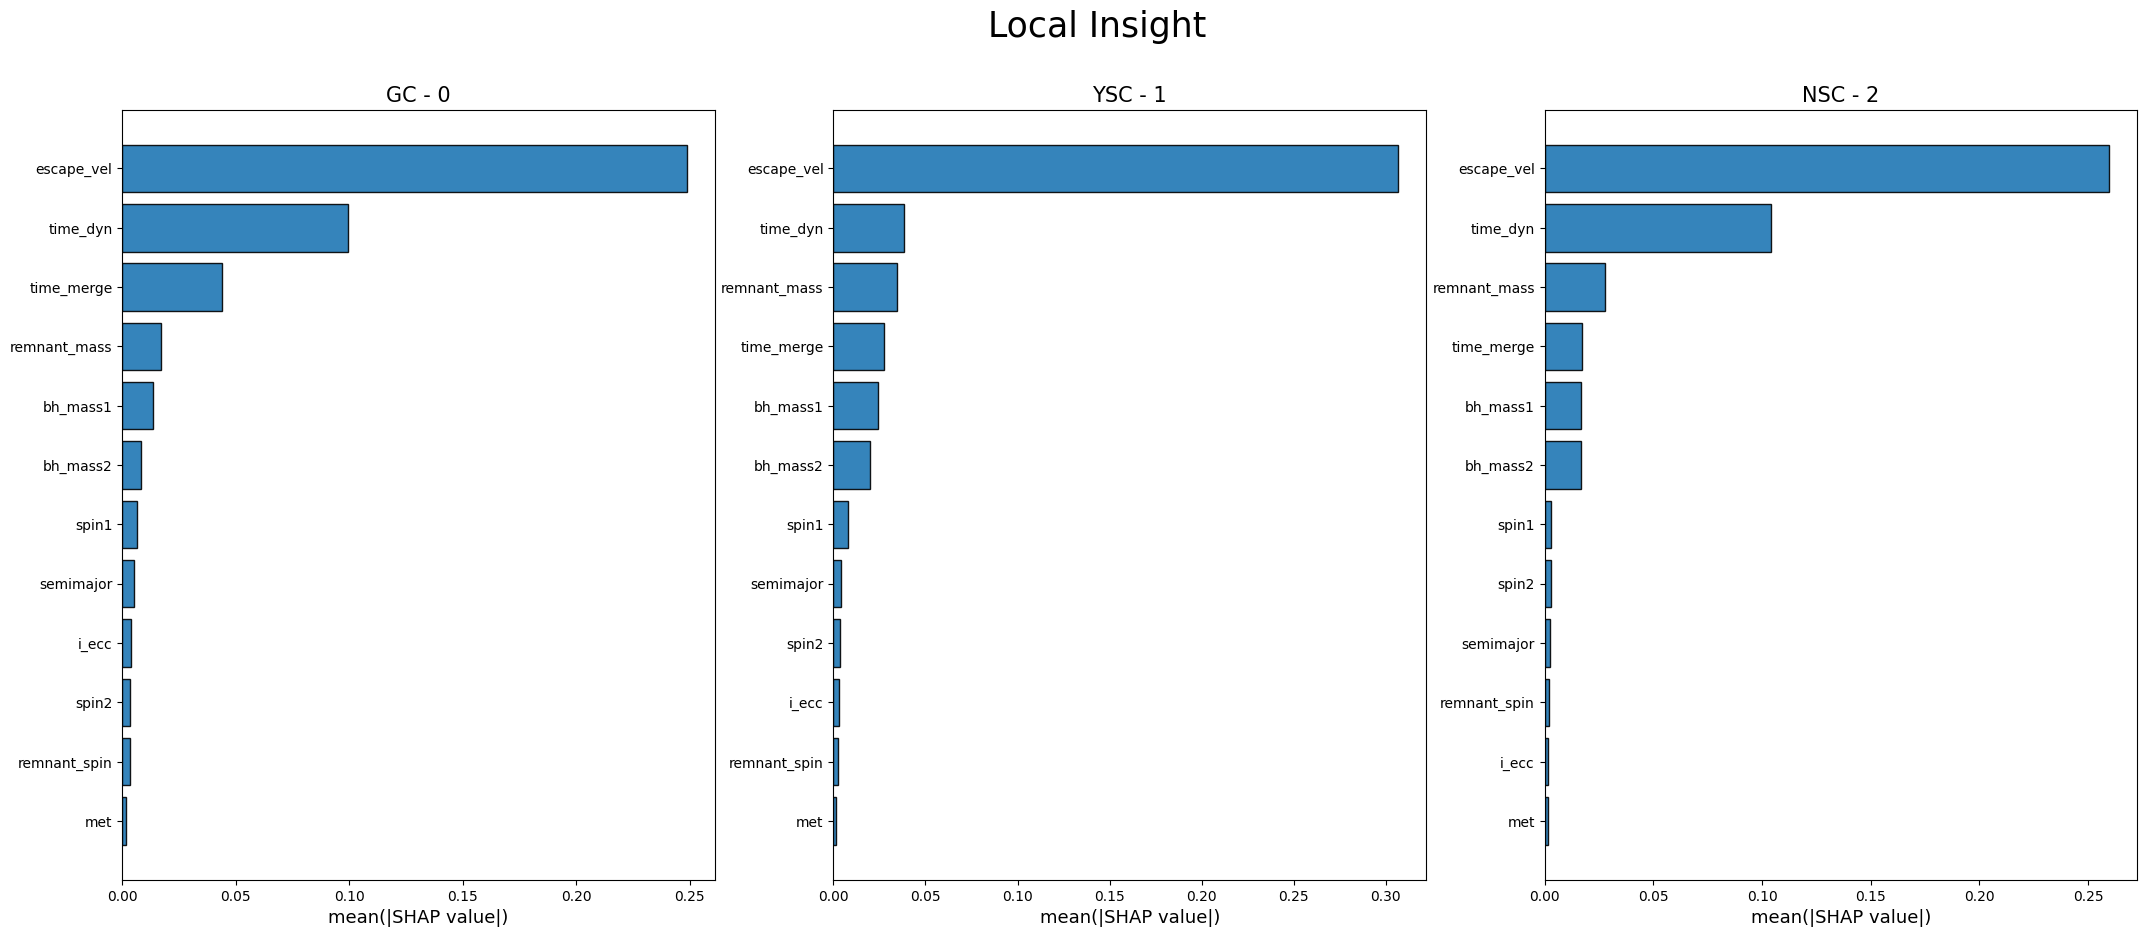

In [43]:
h.plot_shap_bar(lab_shap_values, X_lab_RF)

### 6.2.2 Summary plot (violin type) for each label

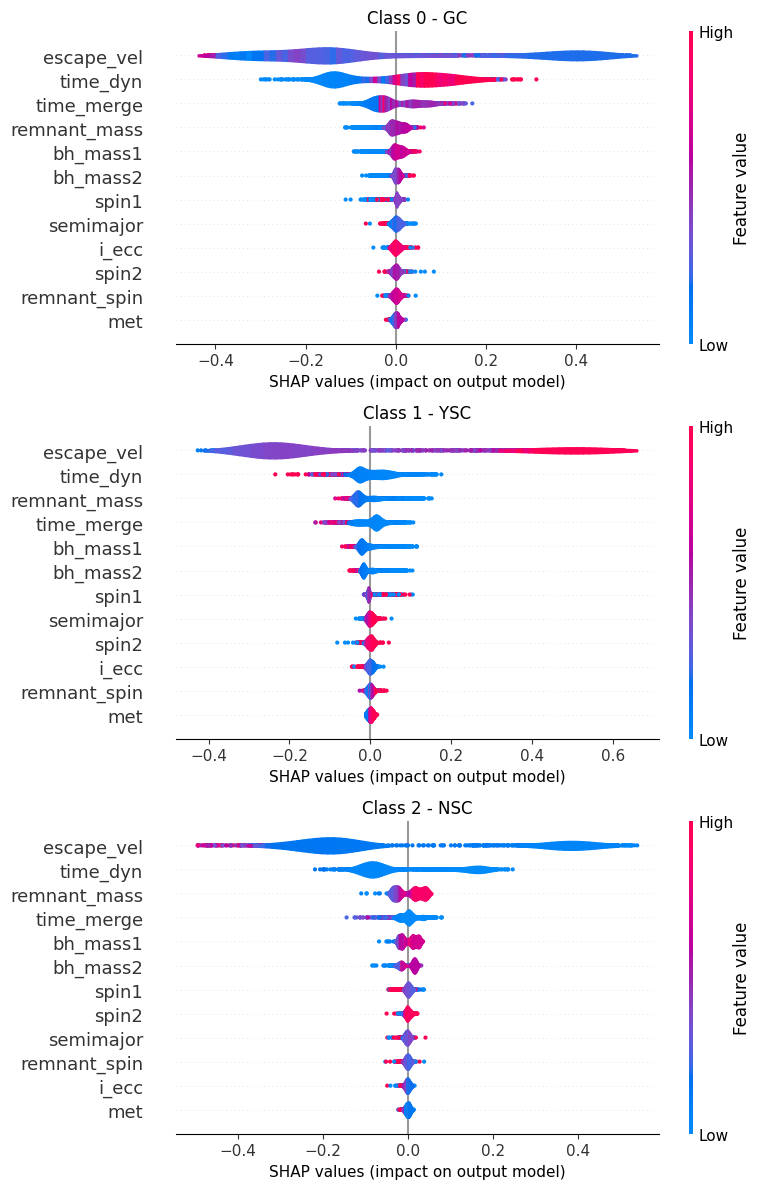

In [44]:
h.plot_shap_violin(shap_values=lab_shap_values, data=X_test_lab_RF, X=X_lab_RF, n_sample=None)

Here we try to give an astrophysical interpretation of the results illustrated by the plot above. 
- **Globular Cluster (GC)**:
    - `escape_vel`: The contribution is not overall clear. GCs have mid to low escape velocities, so it seems consistent with the result, but we cannot draw any strong conclusion.
    - `time_dyn`: High values are preferred, although there is some overlapping with lower values. The dynamical formation timescales, for the simulated systems, for GCs are picked $t_{dyn} \sim 20-200$ Myr.
    - `time_merge`: Middle to high values are preferred. Systems in GCs have a longer lifetime and also the lifetime of GCs is higher ($\sim 12$ Gyr). Thus systems, that produce n-th generations, can have longer merging timescales.
    - `remnant_mass`: Mild contribution by middle-high values. This is because first-generation systems can have higher masses and in turn the remnants.
    - `bh_mass1` and `bh_mass2`: Mild contribution by middle-high values. This is related to the explanation given for `remnant_mass`.

---------------------

- **Young Stellar Cluster (YSC)**:
  - `escape_vel`: This has no astrophysical meaning since YSCs are the less massive host cluster and thus they have the lowest escape velocities. Therefore we should see a positive contribution from low escape velocity values.
  - `time_dyn`: Low values are favored. The dynamical formation timescales, for the simulated systems, are squeezed to lower values for YSCs ($t_{dyn} \sim 3-20$ Myr).
  - `remnant_mass`: Low values contribute mildly. In YSCs first-generation systems tend to have lower masses and thus the remnant masses will be lower compared to binary systems in GCs and NSCs.
  - `bh_mass1` and `bh_mass2`: Lower masses of both BHs contribute mildly. This is related to the explanation given for `remnant_mass`.
  - `time_merge`: Systems in YSCs have a shorter lifetime, so it is difficult to merge within Hubble time. Thus systems, that produce n-th generation, that have a low merging timescale are more likely that belong to YSCs.

-----------------------

- **Nuclear Stellar Cluster (NSC)**:
  - `escape_vel`: NSCs have the largest masses, so they have the largest escape velocity. The result in the plot is inconsistent from an astrophysical point of view.
  - `time_dyn`: The lifetime of NSCs is closer to Hubble time ($\sim 13.6$ Gyr). So systems, to form n-th generations, can have a spread of timescales. The result in the plot is not exhaustive from an astrophysical point of view.
  - `time_merge`: Since the lifetime of NCSs is $\sim 13.6$ Gyr, the merger time can reach higher values. The result in the plot is not exhaustive from an astrophysical point of view.
  - The other features are astrophysically correct but contribute very little to the classification of systems in NSCs.

## 6.3 `label_ngen` features importance

For this task, we will try to give an astrophysical explanation, but since the model struggles to classify correctly $\sim 20\%$ of the dataset, we cannot be sure about the provided explanations.

We will focus on the top 5 features, either for brevity and for the fact that they retain almost the totality of the features importance.

In [45]:
ngen_shap_values = h.shap_explainer(RF_best_ngen, X_test_ngen_RF, n_sample=None)

### 6.3.1 Summary plot (bar type)

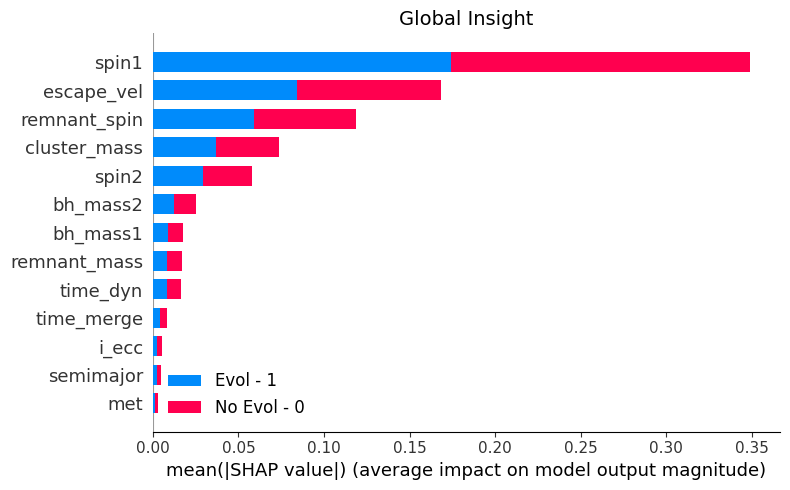

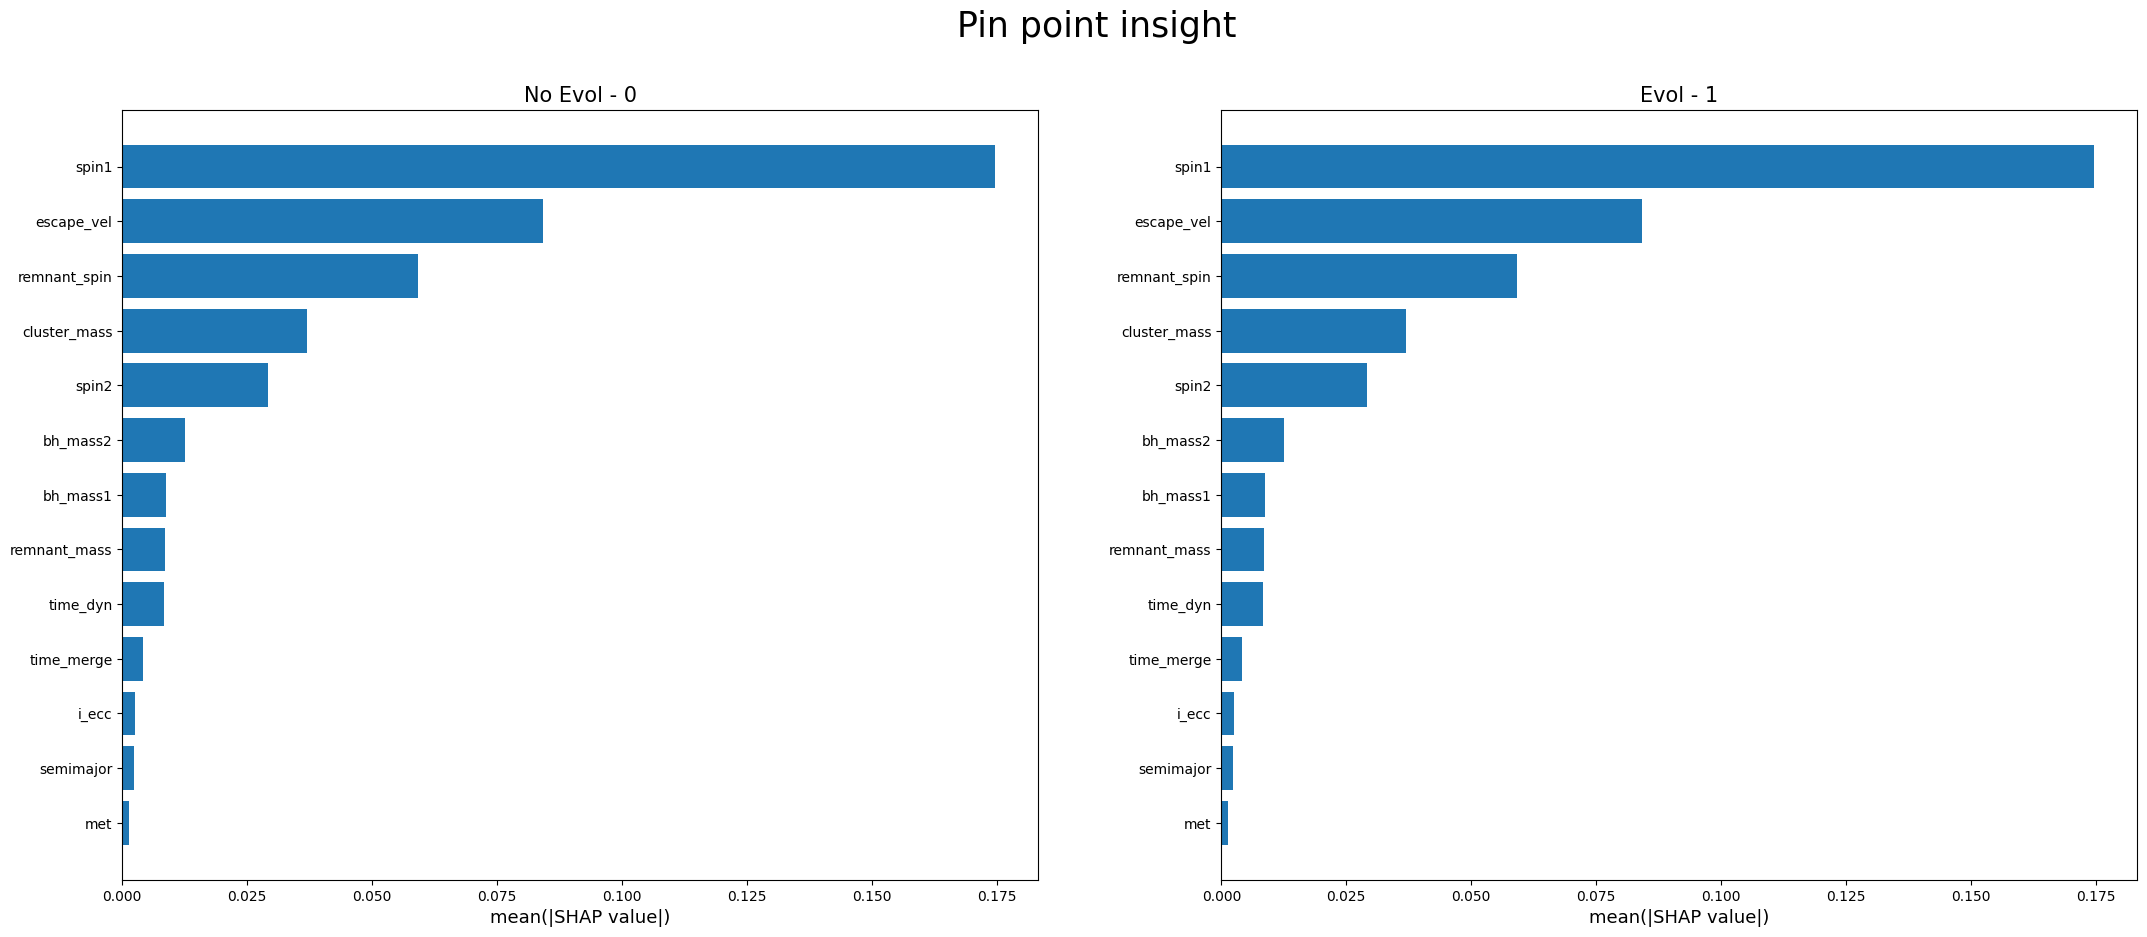

In [46]:
h.plot_shap_bar(shap_values=ngen_shap_values, X=X_ngen_RF)

### 6.3.2 Summary plot (violin type) for each label

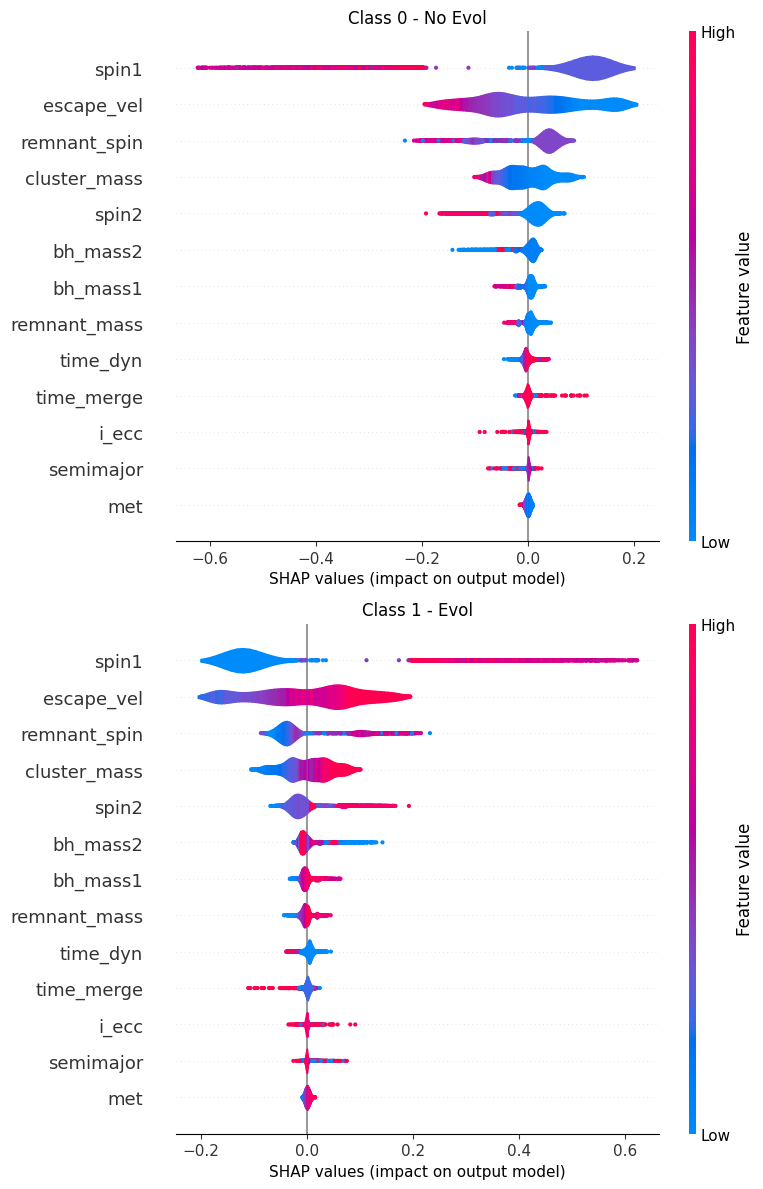

In [47]:
h.plot_shap_violin(shap_values=ngen_shap_values, data=X_test_ngen_RF, X=X_ngen_RF, n_sample=None)

Here we try to give an astrophysical interpretation of the results illustrated by the plot above.

- **No Evolution**:
  - `spin1`: This feature appears to be the most favorable one in distinguishing between a system that evolves and a system that does not. Larger spins are associated with larger relativistic kicks. Higher kick velocities mean that they can be $\ge$ the escape velocity relative to the host stellar cluster. If $v_{kick} \gt v_{esc}$ the remnant can be ejected and it cannot acquire a new companion.  
  From the results, middle-low values of primary black hole spin seem to maintain the system in the current $2^{nd}$ binary BH generation evolution state, while high spin magnitudes seem to suppress the efficiency of hierarchical mergers. From the literature, we know that the impact of spin values is much larger for GCs and YSCs.
  - `escape_velocity`: Low escape velocities are favored. This is because lower $v_{esc}$ allow BHs to be ejected from the system and so they cannot acquire a new companion. In this sense, YSCs have the lowest efficiencies, due to their low $v_{esc}$.
  - `remnant_spin`: The contribution is not clear, but is in a sense related to the explanation given for `spin1`.
  - `cluster_mass`: Low cluster masses are favored. The parameter that mainly affects the escape velocity is cluster mass, since $v_{esc} \propto M^{1/3}$. Therefore low cluster mass means low escape velocity and it's easier for a BH to escape the system.
  - `spin2`: A negative contribution is given by high spin magnitudes. This is related to the explanation given for `spin1`.

-------------------------------------
- **Further Evolution**: Since is a binary classification task (positive vs negative), what was written for "no evolution" applies, in the opposite way, to label 1.

# 7. Conclusions and future work

We investigated the differences between hierarchical binary black hole mergers in NSCs, GCc and YSc and HMs efficiency. 
We considered two different machine learning algorithms: a `RandomForestClassifier` and `XGBoostClassifier`. Both models are based on tree ensemble, but the optimization is different.  
Before training the models we studied which dataset setup would lead to better results, using a simple-as-possible RandomForest model. The benchmarking led us to the conclusion that a balanced (label-wise) dataset is preferable and that we could have reached high performance using a reduced dataset, gaining computational efficiency (i.e. faster training).  

To retrieve the best model, we performed a grid search on a grid of different hyperparameters. The results of the two models for the two tasks were very close, thus we decided to use only the `RandomForestClassifier` model in our final analysis. Both classifiers performed greatly on the task concerning the classification of the stellar clusters, reaching both high accuracy and high classification scores. 
In the task concerning the classification with labeling `label_ngen`, two different models struggle to classify approximately 25%/30% of label `1`, despite the dataset being balanced and the models not exhibiting strong overfitting. There can be multiple causes, for example: data might contain patterns that are inherently difficult to capture or the models used are too complex or too simple for the given task. In future work, other machine learning algorithms may be tried, such as a CNN, which is more flexible in understanding patterns and substructures in a dataset.

We struggled to give an astrophysical interpretation of the features related to the first task. The YSCs are well described while both GCs and NSCs not. Maybe with a different machine learning algorithm and purpose-built dataset, we can achieve better and more explicative results.
The features found in analyzing the SHAP values related to the `label_ngen` task, i.e. assessing the hierarchical mergers efficiency, almost correspond with the ones derived by "classical" statistics methods. One possible evolution to study the efficiency of hierarchical mergers in more detail is to study systems of BHs in their stellar cluster hosts individually, to gain more insights in features importance in different type of stellar clusters. 